# Experimental Design

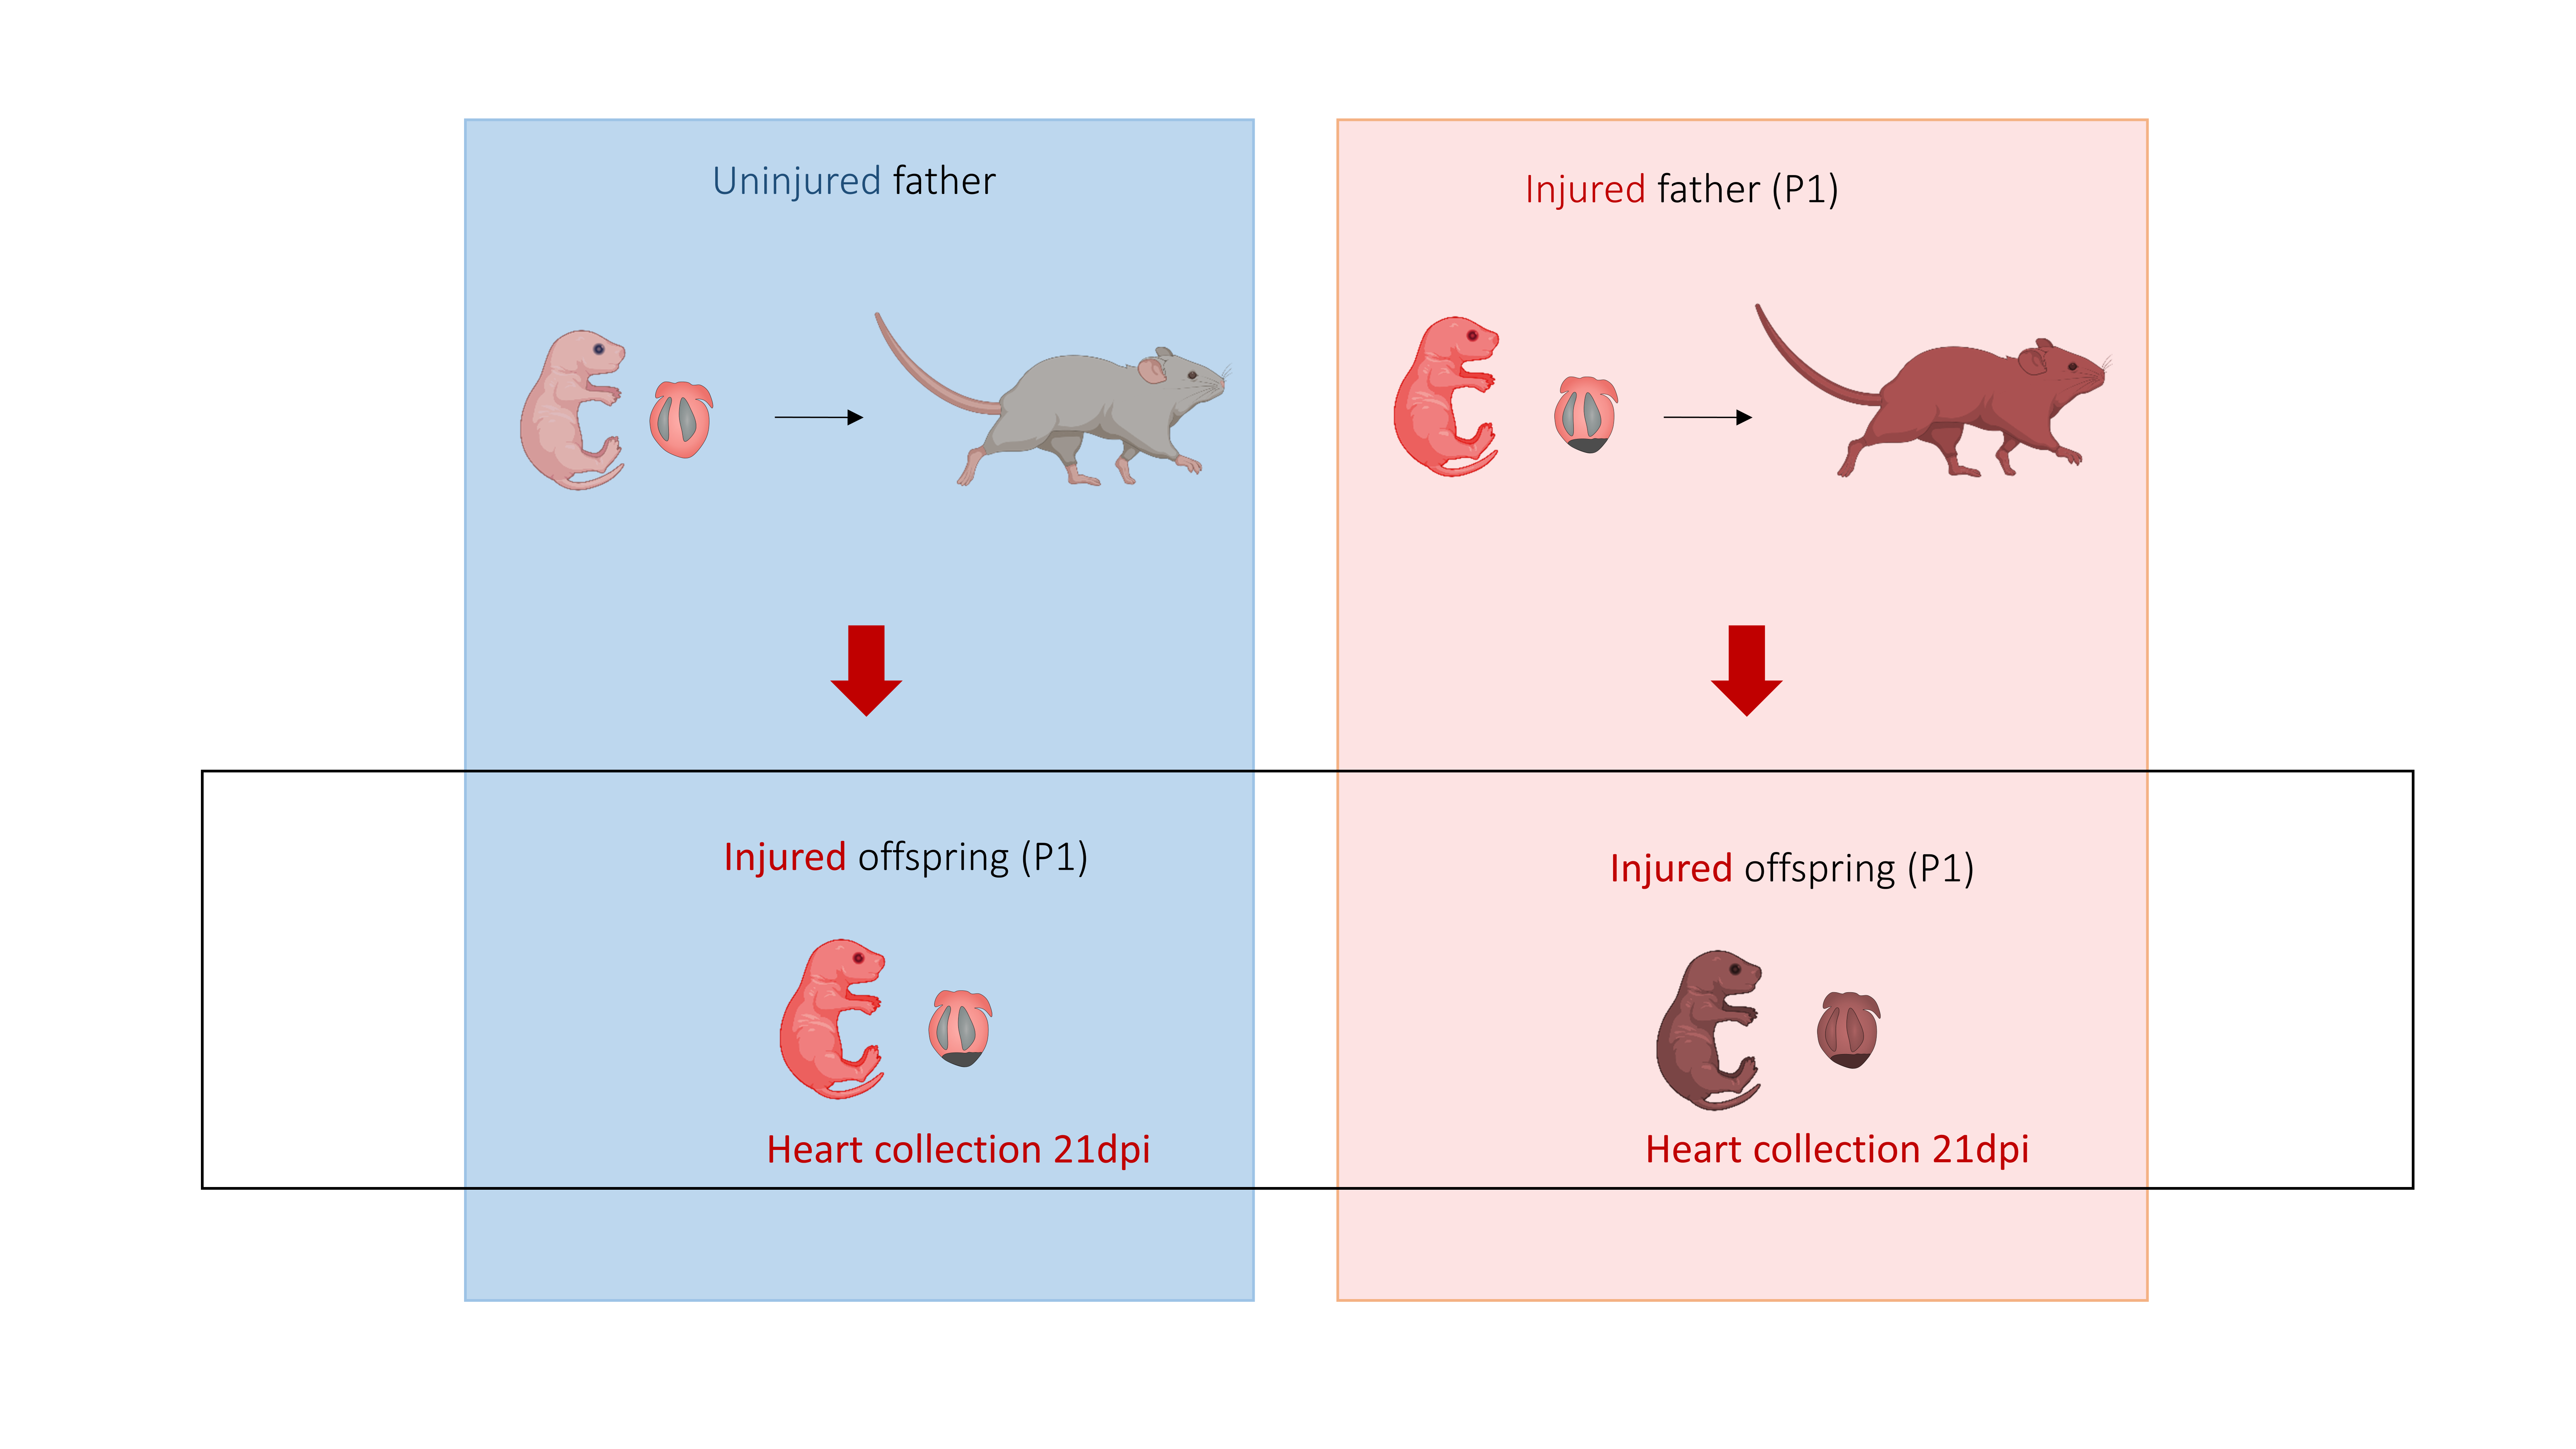

## Clear memory, set working directory, load libraries

In [ ]:
rm(list = ls()) # clear the workspace
gc() # clear the memory
setwd("Benedetta/Benedetta_snRNA-seq_F1_mouse") # set the working directory
getwd() # check the working directory


In [2]:
options(future.globals.maxSize = 40 * 1024^3) # for 20 Gb RAM # set the maximum size of the global environment for the future package for parallel computing
options(future.seed = TRUE) # set seed for reproducibility


In [3]:
# install.packages("unix")
# library(unix)
# rlimit_as(42949672960, max= 43000000000)  #increases to ~12GB


In [ ]:
# load the libraries
library(tidyverse)
library(Seurat)
library(patchwork)
library(repr)
options(repr.plot.width = 16, repr.plot.height = 10) # change the size of the plots
library(dittoSeq)
library(paletteer)
library(ggpattern)
# library(future)
library(liana)
library(viridis)
library(cowplot)
library(clusterProfiler)
library(viridis)
library(Libra)
plan("multicore", workers = 4) # set the number of cores for parallel computing
# bp <- MulticoreParam( RNGseed=1234)


#  Read Data for each sample

## S1

In [101]:
# load the data for the first sample
s1_seurat <- Read10X("Processed_cell_ranger/S1_Gex/outs/filtered_feature_bc_matrix/")


In [ ]:
# create the Seurat object for the first sample
s1_seurat <- CreateSeuratObject(s1_seurat, project = "CI_1")
s1_seurat


In [ ]:
# load the doublet scores for the first sample
doublet_s1 <- read.csv("scrublet_outs/S1_Gex_doublet_score.csv")
head(doublet_s1)
dim(doublet_s1)


In [ ]:
# merge the doublet scores with the Seurat object for the first sample
s1_seurat@meta.data <- cbind(s1_seurat@meta.data, doublet_s1)
s1_seurat@meta.data %>% head()


In [8]:
# calculate the percentage of mitochondrial genes for the first sample
s1_seurat[["percent.mt"]] <- PercentageFeatureSet(s1_seurat, pattern = "^mt-")


In [ ]:
# calulate the meadian percentage of mitochondria, number of genes and the number of UMIs for the first sample
median(s1_seurat@meta.data$percent.mt)
median(s1_seurat@meta.data$nCount_RNA)
median(s1_seurat@meta.data$nFeature_RNA)
dim(s1_seurat@meta.data)


In [ ]:
# plot the relation of the percentage mitochondria and the number of UMIs for the first sample
plot1 <- FeatureScatter(s1_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
# plot the percentage of relation of the number of genes and the number of UMIs for the first sample
plot2 <- FeatureScatter(s1_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

options(repr.plot.width = 12, repr.plot.height = 12)
plot1 + plot2
# plot the percentage of mitochondrial genes, number of genes and the number of UMIs for the first sample
VlnPlot(s1_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [ ]:
# filter the cells for the first sample based on the number of genes, the number of UMIs, the percentage of mitochondrial genes and the doublet scores
s1_seurat <- subset(s1_seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 &
    percent.mt < 20 & nCount_RNA < 20000 &
    predicted_doublets == "False")
s1_seurat


In [ ]:
counts <- GetAssayData(s1_seurat, assay = "RNA")
non_mt_genes <- rownames(counts)[!grepl("^mt-", rownames(counts))]
s1_seurat <- subset(s1_seurat, features = non_mt_genes)
s1_seurat
s1_seurat[["percent.mt_after_removal"]] <- PercentageFeatureSet(s1_seurat, pattern = "^mt-")
VlnPlot(s1_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.mt_after_removal"), ncol = 3)


In [ ]:
s1_seurat <- SCTransform(s1_seurat, verbose = FALSE, vars.to.regress = "percent.mt") %>%
    RunPCA(npcs = 50, verbose = FALSE)


##  S2

In [ ]:
s2_seurat <- Read10X("Processed_cell_ranger/S2_GeX/outs/filtered_feature_bc_matrix/")
s2_seurat <- CreateSeuratObject(s2_seurat, project = "CI_2")
s2_seurat


In [ ]:
doublet_s2 <- read.csv("scrublet_outs/S2_GeX_doublet_score.csv")
head(doublet_s2)
dim(doublet_s2)


In [ ]:
s2_seurat@meta.data <- cbind(s2_seurat@meta.data, doublet_s2)
s2_seurat@meta.data %>% head()


In [17]:
s2_seurat[["percent.mt"]] <- PercentageFeatureSet(s2_seurat, pattern = "^mt-")


In [ ]:
plot1 <- FeatureScatter(s2_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(s2_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2
VlnPlot(s2_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [ ]:
s2_seurat <- subset(s2_seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 6000 &
    percent.mt < 20 & nCount_RNA < 20000 &
    predicted_doublets == "False")
s2_seurat


In [ ]:
VlnPlot(s2_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [ ]:
counts <- GetAssayData(s2_seurat, assay = "RNA")
non_mt_genes <- rownames(counts)[!grepl("^mt-", rownames(counts))]
s2_seurat <- subset(s2_seurat, features = non_mt_genes)
s2_seurat
s2_seurat[["percent.mt_after_removal"]] <- PercentageFeatureSet(s2_seurat, pattern = "^mt-")
VlnPlot(s2_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.mt_after_removal"), ncol = 3)


In [ ]:
s2_seurat <- SCTransform(s2_seurat, verbose = FALSE, vars.to.regress = "percent.mt") %>%
    RunPCA(npcs = 50, verbose = FALSE)


## S3

In [ ]:
s3_seurat <- Read10X("Processed_cell_ranger/S3_GeX/outs/filtered_feature_bc_matrix/")
s3_seurat <- CreateSeuratObject(s3_seurat, project = "Ctrl_1")
s3_seurat


In [ ]:
doublet_s3 <- read.csv("scrublet_outs/S3_GeX_doublet_score.csv")
head(doublet_s3)
dim(doublet_s3)


In [ ]:
s3_seurat@meta.data <- cbind(s3_seurat@meta.data, doublet_s3)
s3_seurat@meta.data %>% head()


In [26]:
s3_seurat[["percent.mt"]] <- PercentageFeatureSet(s3_seurat, pattern = "^mt-")


In [ ]:
plot1 <- FeatureScatter(s3_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(s3_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2
VlnPlot(s3_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [ ]:
s3_seurat <- subset(s3_seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 &
    percent.mt < 20 & nCount_RNA < 20000 &
    predicted_doublets == "False")
s3_seurat


In [ ]:
VlnPlot(s3_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [ ]:
ccounts <- GetAssayData(s3_seurat, assay = "RNA")
non_mt_genes <- rownames(counts)[!grepl("^mt-", rownames(counts))]
s3_seurat <- subset(s3_seurat, features = non_mt_genes)
s3_seurat
s3_seurat[["percent.mt_after_removal"]] <- PercentageFeatureSet(s3_seurat, pattern = "^mt-")
VlnPlot(s3_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.mt_after_removal"), ncol = 3)


In [ ]:
s3_seurat <- SCTransform(s3_seurat, verbose = FALSE, vars.to.regress = "percent.mt") %>%
    RunPCA(npcs = 50, verbose = FALSE)


## S4

In [ ]:
s4_seurat <- Read10X("Processed_cell_ranger/S4_GeX/outs/filtered_feature_bc_matrix/")
s4_seurat <- CreateSeuratObject(s4_seurat, project = "Ctrl_2")
s4_seurat


In [ ]:
doublet_s4 <- read.csv("scrublet_outs/S4_GeX_doublet_score.csv")
head(doublet_s4)
dim(doublet_s4)


In [ ]:
s4_seurat@meta.data <- cbind(s4_seurat@meta.data, doublet_s4)
s4_seurat@meta.data %>% head()


In [35]:
s4_seurat[["percent.mt"]] <- PercentageFeatureSet(s4_seurat, pattern = "^mt-")


In [ ]:
plot1 <- FeatureScatter(s4_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(s4_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2
VlnPlot(s4_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [ ]:
s4_seurat <- subset(s4_seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 &
    percent.mt < 20 & nCount_RNA < 20000 &
    predicted_doublets == "False")
s4_seurat


In [ ]:
VlnPlot(s4_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [ ]:
counts <- GetAssayData(s4_seurat, assay = "RNA")
non_mt_genes <- rownames(counts)[!grepl("^mt-", rownames(counts))]
s4_seurat <- subset(s4_seurat, features = non_mt_genes)
s4_seurat
s4_seurat[["percent.mt_after_removal"]] <- PercentageFeatureSet(s4_seurat, pattern = "^mt-")
VlnPlot(s4_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.mt_after_removal"), ncol = 3)


In [ ]:
s4_seurat <- SCTransform(s4_seurat, verbose = FALSE, vars.to.regress = "percent.mt") %>%
    RunPCA(npcs = 50, verbose = FALSE)


# Integrate the datasets

In [41]:
all_obj_list <- list(ctrl_1 = s3_seurat, ctrl_2 = s4_seurat, CI_1 = s1_seurat, CI_2 = s2_seurat)


In [42]:
features <- SelectIntegrationFeatures(object.list = all_obj_list, nfeatures = 3000)


In [ ]:
all_obj_list <- PrepSCTIntegration(object.list = all_obj_list, anchor.features = features)


In [ ]:
cell_anchors <- FindIntegrationAnchors(
    object.list = all_obj_list, normalization.method = "SCT",
    anchor.features = features
)
all_obj_list_sct <- IntegrateData(anchorset = cell_anchors, normalization.method = "SCT")


In [78]:
combined_sct <- RunPCA(all_obj_list_sct, verbose = FALSE)


In [ ]:
print(combined_sct[["pca"]], dims = 1:5, nfeatures = 5)


In [ ]:
DimPlot(combined_sct, reduction = "pca")


In [ ]:
ElbowPlot(combined_sct, ndims = 50)


## Clustering

In [ ]:
combined_sct <- RunUMAP(combined_sct, reduction = "pca", dims = 1:30, verbose = FALSE)
combined_sct <- FindNeighbors(combined_sct, reduction = "pca", dims = 1:30)
combined_sct <- FindClusters(combined_sct, resolution = 0.4)


In [ ]:
combined_sct@meta.data %>% head()
combined_sct@meta.data %>% tail()
combined_sct@meta.data$`integrated_snn_res.0.3` %>% unique()


## UMAP with no annotation and showing normalizaton across datasets

In [ ]:
DimPlot(combined_sct, reduction = "umap", label = TRUE)


In [ ]:
DimPlot(combined_sct, reduction = "umap", label = TRUE, group.by = "orig.ident")


In [ ]:
combined_markers <- FindAllMarkers(combined_sct, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)


In [87]:
write.csv(combined_markers, "cluster_markers_no_soupx.csv")


## Check Cluster Markers

In [ ]:
genes_fig1D_wang <- c("Myh6", "Cdh5", "Pecam1", "Pdgfra", "Msln", "Myh11", "Kcnj8", "Adgre1", "Itgal", "Naaa", "S100a9", "Cd3g", "Ms4a1", "Plp1", "Hbb-bt", "Hba-a1")
VlnPlot(object = combined_sct, features = c(genes_fig1D_wang, "Cthrc1"), stack = TRUE) + NoLegend()


In [89]:
Fig_2_Hesse_eLife2022 <- c(
    "Wt1", "Tbx18", "Sema3d", "Aldh1a2", "Gata5", "Tcf21", # epicardial
    "Nkain4", "Lgals7", "Dmkn", "Upk3b", "Igfb5", "Krt7", "Krt18", "Myl7", "Msln", "Krt14", # EpiSC7
    "Dpt", "Gpx3", "Tnc", "Lum", "Ptn", "Cxcl12", "Tagln", "Acta2", "serpinb2", "Spp1", # EpiSC-8
    "Tpt1", "Rps21", "mt-Co1", "Cd44", "AC160336.1" # EpiSC1.5
)


In [ ]:
FeaturePlot(combined_sct, features = Fig_2_Hesse_eLife2022[1:6], label = TRUE, ncol = 3)
FeaturePlot(combined_sct, features = Fig_2_Hesse_eLife2022[7:16], label = TRUE, ncol = 3)
FeaturePlot(combined_sct, features = Fig_2_Hesse_eLife2022[17:25], label = TRUE, ncol = 3)
VlnPlot(object = combined_sct, features = Fig_2_Hesse_eLife2022, stack = TRUE) + NoLegend()


## Annotate Clusters

In [ ]:
cluster_identity <- read.csv(file = "cluster_annotation_no_soupx.csv") # made a table manually after going throught the feature plots to help assign the cluster name

cluster_identity
new.cluster.ids <- cluster_identity$Cell_type
names(new.cluster.ids) <- levels(combined_sct)
names(new.cluster.ids)


In [94]:
combined_sct <- RenameIdents(combined_sct, new.cluster.ids)


### UMAP with Annotated clusters

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)
DimPlot(combined_sct, reduction = "umap", label = TRUE)
DimPlot(combined_sct, reduction = "umap", label = TRUE, group.by = "seurat_clusters")
DimPlot(combined_sct, reduction = "umap", label = TRUE, group.by = "orig.ident")


In [ ]:
combined_sct@meta.data$cell_name <- rownames(combined_sct@meta.data)
combined_sct@meta.data %>% head()
combined_sct@meta.data %>% dim()
combined_sct@meta.data <- merge(combined_sct@meta.data, cluster_identity, by.x = "integrated_snn_res.0.4", by.y = "Cluster")
rownames(combined_sct@meta.data) <- combined_sct@meta.data$cell_name
combined_sct@meta.data %>% head()


In [ ]:
combined_sct@meta.data$condition <- NA
combined_sct@meta.data$condition[grepl("CI", combined_sct@meta.data$orig.ident)] <- "CI"
combined_sct@meta.data$condition[grepl("Ctrl", combined_sct@meta.data$orig.ident)] <- "Ctrl"
combined_sct@meta.data %>% head()
combined_sct@meta.data %>% tail()


In [ ]:
genes_fig1D_wang <- c("Myh6", "Cdh5", "Pdgfra", "Msln", "Myh11", "Kcnj8", "Adgre1", "Itgal", "Naaa", "S100a9", "Cd3g", "Ms4a1", "Plp1", "Hbb-bt", "Hba-a1")
VlnPlot(object = combined_sct, features = c(genes_fig1D_wang, "Cthrc1"), stack = TRUE) + NoLegend()


# CM Subclusters

In [ ]:
combined_sct_CM <- subset(combined_sct, idents = c("CM_1", "CM_2", "CM_3", "CM_4"))

combined_sct_CM


In [ ]:
combined_sct_CM <- SCTransform(combined_sct_CM, verbose = FALSE)


In [159]:
# These are now standard steps in the Seurat workflow for visualization and clustering
combined_sct_CM <- RunPCA(combined_sct_CM, verbose = FALSE)


In [ ]:
ElbowPlot(combined_sct, ndims = 50)


In [161]:
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
combined_sct_CM <- RunUMAP(combined_sct_CM, dims = 1:30, verbose = FALSE)

combined_sct_CM <- FindNeighbors(combined_sct_CM, dims = 1:30, verbose = FALSE)
combined_sct_CM <- FindClusters(combined_sct_CM, verbose = FALSE, resolution = 0.3)


In [ ]:
DimPlot(combined_sct_CM, label = TRUE)


In [ ]:
combined_sct_CM_markers <- FindAllMarkers(combined_sct_CM, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_CM_markers %>% head()
write.csv(combined_sct_CM_markers, "CM_subcluster_markers_no_soupx.csv")


In [ ]:
combined_sct_CM_markers %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20
options(repr.plot.width = 24, repr.plot.height = 30)
DoHeatmap(combined_sct_CM, features = top20$gene) + NoLegend()
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)

FeaturePlot(combined_sct_CM, features = c("Hba-a1", "Hbb-bt"), label = TRUE, pt.size = 2)
VlnPlot(combined_sct_CM, features = c("Hba-a1", "Hbb-bt"))


In [ ]:
atrial_markers <- c("Nppa", "Myl7", "Myl4")
atrial_markers
FeaturePlot(combined_sct_CM, features = atrial_markers, label = TRUE, split.by = "orig.ident")
FeaturePlot(combined_sct_CM, features = atrial_markers, label = TRUE, )
VlnPlot(combined_sct_CM, features = atrial_markers, stack = TRUE)


In [ ]:
ventricle_markers <- c("Myh7", "Myl2", "Fhl2", "Irx4", "Zscan20", "Ebf3", "Irx5", "Irx2", "Hey2", "Scx", "Tcf15", "Nr2f6", "Rxrg", "Snai3")
ventricle_markers
FeaturePlot(combined_sct_CM, features = ventricle_markers, label = TRUE)
VlnPlot(combined_sct_CM, features = ventricle_markers, stack = TRUE)


In [ ]:
left_artium_markers <- c("Pitx2", "Foxc1", "Bcn1", "Irf6", "Peg3", "Osr1", "Creb3l2", "Zbrb7a")
left_artium_markers
FeaturePlot(combined_sct_CM, features = left_artium_markers, label = TRUE)
VlnPlot(combined_sct_CM, features = left_artium_markers, stack = TRUE)


In [ ]:
Fig_1H_Cui_Devcell2020 <- c(
    "Ank2", "Mhrt", "Fgf13", "Fhl2", "Gm30382", "Gm14091",
    "Top2a", "Lockd", "Casc5", "17000442O10Rik", "Ddc", "Mid1",
    "Atp5", "Mdh2", "Sod2", "Mb", "Xirp2", "Gm13601", "Ankrd1",
    "Enah"
)
FeaturePlot(combined_sct, features = Fig_1H_Cui_Devcell2020, label = TRUE)
FeaturePlot(combined_sct_CM, features = c(Fig_1H_Cui_Devcell2020, "Tbx5"), label = TRUE)
VlnPlot(combined_sct_CM, features = c(Fig_1H_Cui_Devcell2020, "Tbx5"), stack = TRUE)
DotPlot(combined_sct_CM, features = c(Fig_1H_Cui_Devcell2020, "Tbx5"))


## Annotate CM subclusters

Clubbing Cluster 0 and 1 together as they seem very similar

In [ ]:
cluster_identity_CM_sub <- read.csv(file = "cluster_annotation_CM_sub_no_soupx.csv") # made a table manually after going throught the feature plots to help assign the cluster name
cluster_identity_CM_sub
cluster_identity_CM_sub <- cluster_identity_CM_sub %>% rename(Cell_type_CM_sub = Cell_type)
new.cluster.ids <- cluster_identity_CM_sub$Cell_type_CM_sub

names(new.cluster.ids) <- levels(combined_sct_CM)
names(new.cluster.ids)


In [173]:
combined_sct_CM <- RenameIdents(combined_sct_CM, new.cluster.ids)


In [ ]:
combined_sct_CM@meta.data %>% head()


In [ ]:
combined_sct_CM@meta.data %>% dim()
combined_sct_CM@meta.data <- merge(combined_sct_CM@meta.data, cluster_identity_CM_sub, by.x = "SCT_snn_res.0.3", by.y = "Cluster")
rownames(combined_sct_CM@meta.data) <- combined_sct_CM@meta.data$cell_name
combined_sct_CM@meta.data %>% head()


In [ ]:
DimPlot(combined_sct_CM, label = TRUE)


In [ ]:
combined_sct_CM@meta.data %>% names()


In [ ]:
table(combined_sct_CM@meta.data$`Cell_type_CM_sub`, combined_sct_CM@meta.data$orig.ident)


In [ ]:
combined_sct_CM_cells_per_condition <- table(combined_sct_CM@meta.data$`Cell_type_CM_sub`, combined_sct_CM@meta.data$orig.ident)
combined_sct_CM_cells_per_condition
write.csv(combined_sct_CM_cells_per_condition, "number_of_cellls_per_CM_subcluster_type_no_soupx.csv")

combined_sct_CM_cells_per_condition_proportion <- sweep(combined_sct_CM_cells_per_condition, 2, colSums(combined_sct_CM_cells_per_condition), `/`)
combined_sct_CM_cells_per_condition_proportion <- combined_sct_CM_cells_per_condition_proportion * 100
combined_sct_CM_cells_per_condition_proportion
write.csv(combined_sct_CM_cells_per_condition_proportion, "percentage_of_cellls_per_CM_subcluster_type_no_soupx.csv")




combined_sct_CM_cells_per_condition_proportion <- as.data.frame(combined_sct_CM_cells_per_condition_proportion)
combined_sct_CM_cells_per_condition_proportion <- combined_sct_CM_cells_per_condition_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

combined_sct_CM_cells_per_condition_proportion$condition <- NA
combined_sct_CM_cells_per_condition_proportion$condition[grepl("CI", combined_sct_CM_cells_per_condition_proportion$Sample)] <- "CI"
combined_sct_CM_cells_per_condition_proportion$condition[grepl("Ctrl", combined_sct_CM_cells_per_condition_proportion$Sample)] <- "Ctrl"
combined_sct_CM_cells_per_condition_proportion %>% head()
combined_sct_CM_cells_per_condition_proportion %>% tail()


combined_sct_CM_cells_per_condition_proportion %>% head()

ggplot(combined_sct_CM_cells_per_condition_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


## Find markers based on the grouped clusters

In [ ]:
combined_sct_CM_markers_grouped <- FindAllMarkers(combined_sct_CM, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_CM_markers_grouped %>% head()
write.csv(combined_sct_CM_markers_grouped, "CM_subcluster_markers_grouped_no_soupx.csv")


In [ ]:
combined_sct_CM_markers_grouped %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20
options(repr.plot.width = 24, repr.plot.height = 30)
DoHeatmap(combined_sct_CM, features = top20$gene) + NoLegend()
options(repr.plot.width = 16, repr.plot.height = 10)


## Transfer CM sub labels to big Seurat object

In [ ]:
CM_sub_labels <- combined_sct_CM@meta.data %>% select(cell_name, Cell_type_CM_sub)
head(CM_sub_labels)
class(CM_sub_labels)


In [ ]:
combined_sct@meta.data <- merge(combined_sct@meta.data, CM_sub_labels, by = "cell_name", all = TRUE)
combined_sct@meta.data %>% head()


In [ ]:
combined_sct@meta.data$Cell_type_CM_sub[is.na(combined_sct@meta.data$Cell_type_CM_sub)] <-
    combined_sct@meta.data$Cell_type[is.na(combined_sct@meta.data$Cell_type_CM_sub)]

combined_sct@meta.data$Cell_type_CM_sub %>% unique()


In [ ]:
rownames(combined_sct@meta.data) <- combined_sct@meta.data$cell_name
combined_sct@meta.data %>% head()


In [ ]:
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_CM_sub")


## Percentage of cells based on CM subclusters

In [ ]:
cell_per_condition_all_withCMsub <- table(combined_sct@meta.data$`Cell_type_CM_sub`, combined_sct@meta.data$orig.ident)
cell_per_condition_all_withCMsub
write.csv(cell_per_condition_all_withCMsub, "number_of_cellls_all_with_CM_subclusters_no_soupx.csv")

cell_per_condition_all_withCMsub_proportion <- sweep(cell_per_condition_all_withCMsub, 2, colSums(cell_per_condition_all_withCMsub), `/`)
cell_per_condition_all_withCMsub_proportion <- cell_per_condition_all_withCMsub_proportion * 100
cell_per_condition_all_withCMsub_proportion
write.csv(cell_per_condition_all_withCMsub_proportion, "percentage_of_cellls_all_with_CM_subclusters_no_soupx.csv")




cell_per_condition_all_withCMsub_proportion <- as.data.frame(cell_per_condition_all_withCMsub_proportion)
cell_per_condition_all_withCMsub_proportion <- cell_per_condition_all_withCMsub_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

cell_per_condition_all_withCMsub_proportion$condition <- NA
cell_per_condition_all_withCMsub_proportion$condition[grepl("CI", cell_per_condition_all_withCMsub_proportion$Sample)] <- "CI"
cell_per_condition_all_withCMsub_proportion$condition[grepl("Ctrl", cell_per_condition_all_withCMsub_proportion$Sample)] <- "Ctrl"
cell_per_condition_all_withCMsub_proportion %>% head()
cell_per_condition_all_withCMsub_proportion %>% tail()


cell_per_condition_all_withCMsub_proportion %>% head()

ggplot(cell_per_condition_all_withCMsub_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


# EC Subclusters 

In [ ]:
combined_sct_EC <- subset(combined_sct, idents = c("EC_1", "EC_2", "EC_3", "EC_4", "EC_5"))

combined_sct_EC


In [ ]:
combined_sct_EC <- SCTransform(combined_sct_EC, verbose = FALSE, vars.to.regress = "percent.mt")


In [ ]:
# These are now standard steps in the Seurat workflow for visualization and clustering
combined_sct_EC <- RunPCA(combined_sct_EC, verbose = FALSE)
ElbowPlot(combined_sct_EC, ndims = 50)


In [ ]:
combined_sct_EC <- RunUMAP(combined_sct_EC, dims = 1:30, verbose = FALSE)
combined_sct_EC <- FindNeighbors(combined_sct_EC, dims = 1:30, verbose = FALSE)
combined_sct_EC <- FindClusters(combined_sct_EC, verbose = FALSE, resolution = 0.1)
DimPlot(combined_sct_EC, label = TRUE) + NoLegend()


In [ ]:
DimPlot(combined_sct_EC, label = TRUE, group.by = "Cell_type") + NoLegend()


The re-clustering of ECs looks better than the previous clustering. So changing it to the new one

In [ ]:
combined_sct_EC@meta.data %>% head()


In [ ]:
combined_sct_EC_markers <- FindAllMarkers(combined_sct_EC, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_EC_markers %>% head()
write.csv(combined_sct_EC_markers, "EC_subcluster_markers_no_soupx.csv")


In [ ]:
combined_sct_EC_markers %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20

DoHeatmap(combined_sct_EC, features = top20$gene) + NoLegend()


In [ ]:
combined_sct_EC@meta.data %>% head()


## Annotate the EC subclusters

In [ ]:
cluster_identity_EC_sub <- read.csv(file = "cluster_annotation_EC_sub_no_soupx.csv") # made a table manually after going throught the feature plots to help assign the cluster name
cluster_identity_EC_sub
cluster_identity_EC_sub <- cluster_identity_EC_sub %>% rename(Cell_type_EC_sub = Cell_type)
new.cluster.ids <- cluster_identity_EC_sub$Cell_type_EC_sub

names(new.cluster.ids) <- levels(combined_sct_EC)
names(new.cluster.ids)


In [224]:
combined_sct_EC <- RenameIdents(combined_sct_EC, new.cluster.ids)


In [ ]:
combined_sct_EC@meta.data %>% dim()
combined_sct_EC@meta.data <- merge(combined_sct_EC@meta.data, cluster_identity_EC_sub, by.x = "SCT_snn_res.0.1", by.y = "Cluster")
rownames(combined_sct_EC@meta.data) <- combined_sct_EC@meta.data$cell_name
combined_sct_EC@meta.data %>% head()


DimPlot(combined_sct_EC, label = TRUE)


## Percentage of cells EC subclusters

In [ ]:
combined_sct_EC_cells_per_condition <- table(combined_sct_EC@meta.data$`Cell_type_EC_sub`, combined_sct_EC@meta.data$orig.ident)
combined_sct_EC_cells_per_condition
write.csv(combined_sct_EC_cells_per_condition, "number_of_cellls_per_EC_subcluster_type_no_soupx.csv")


In [ ]:
combined_sct_EC_cells_per_condition_proportion <- sweep(combined_sct_EC_cells_per_condition, 2, colSums(combined_sct_EC_cells_per_condition), `/`)
combined_sct_EC_cells_per_condition_proportion <- combined_sct_EC_cells_per_condition_proportion * 100
combined_sct_EC_cells_per_condition_proportion
write.csv(combined_sct_EC_cells_per_condition_proportion, "percentage_of_cellls_per_EC_subcluster_type_no_soupx.csv")




combined_sct_EC_cells_per_condition_proportion <- as.data.frame(combined_sct_EC_cells_per_condition_proportion)
combined_sct_EC_cells_per_condition_proportion <- combined_sct_EC_cells_per_condition_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

combined_sct_EC_cells_per_condition_proportion$condition <- NA
combined_sct_EC_cells_per_condition_proportion$condition[grepl("CI", combined_sct_EC_cells_per_condition_proportion$Sample)] <- "CI"
combined_sct_EC_cells_per_condition_proportion$condition[grepl("Ctrl", combined_sct_EC_cells_per_condition_proportion$Sample)] <- "Ctrl"
combined_sct_EC_cells_per_condition_proportion %>% head()
combined_sct_EC_cells_per_condition_proportion %>% tail()


combined_sct_EC_cells_per_condition_proportion %>% head()

ggplot(combined_sct_EC_cells_per_condition_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


## Markers of subclusters based on new annotations

In [ ]:
combined_sct_EC_markers_grouped <- FindAllMarkers(combined_sct_EC, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_EC_markers_grouped %>% head()
write.csv(combined_sct_EC_markers_grouped, "EC_subcluster_markers_grouped_no_soupx.csv")


In [ ]:
combined_sct_EC_markers_grouped %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20

DoHeatmap(combined_sct_EC, features = top20$gene) + NoLegend()


## Check markers from literature

In [ ]:
EC_markers <- c(
    "Cdh5", "Pecam1", "Colec11", "Icam1", "Icam2", "Nectin2", "Fabp5",
    "Cd34", "Entpd1", "Sele", "Vcam1"
)

FeaturePlot(combined_sct, features = EC_markers, label = TRUE)
FeaturePlot(combined_sct_EC, features = EC_markers, label = TRUE)
VlnPlot(combined_sct_EC, features = EC_markers)


In [ ]:
EC_subcluster_markers_Wang <- c(
    "Cxcl12", "Stmn2", "Fbln5", "Eln", "Mgp", "Gpihbp1", "Mest",
    "Dusp2", "Nfkbia", "Atf3", "Icam1", "Hspa1a", "Vwf", "Fbln2", "Igf1", "Cpe", "H19", "Ptn", "Apoe", "Igfbp5", "Hmgb2", "Tuba1b", "Stmn1", "Birc5", "Cenpa"
)
FeaturePlot(combined_sct, features = EC_subcluster_markers_Wang, label = TRUE)


In [ ]:
FeaturePlot(combined_sct_EC, features = EC_subcluster_markers_Wang, label = TRUE)
VlnPlot(combined_sct_EC, features = EC_subcluster_markers_Wang, stack = TRUE)


## Transfer EC sub labels to big Seurat object

In [ ]:
EC_sub_labels <- combined_sct_EC@meta.data %>% select(cell_name, Cell_type_EC_sub)
head(EC_sub_labels)
class(EC_sub_labels)


combined_sct@meta.data <- merge(combined_sct@meta.data, EC_sub_labels, by = "cell_name", all = TRUE)
combined_sct@meta.data %>% head()

combined_sct@meta.data$Cell_type_EC_sub[is.na(combined_sct@meta.data$Cell_type_EC_sub)] <-
    combined_sct@meta.data$Cell_type_CM_sub[is.na(combined_sct@meta.data$Cell_type_EC_sub)]

combined_sct@meta.data$Cell_type_EC_sub %>% unique()

rownames(combined_sct@meta.data) <- combined_sct@meta.data$cell_name
combined_sct@meta.data %>% head()

DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_EC_sub")


## Percentage of cells based on EC subclusters

In [ ]:
cell_per_condition_all_withECsub <- table(combined_sct@meta.data$`Cell_type_EC_sub`, combined_sct@meta.data$orig.ident)
cell_per_condition_all_withECsub
write.csv(cell_per_condition_all_withECsub, "number_of_cellls_all_with_EC_subclusters_no_soupx.csv")

cell_per_condition_all_withECsub_proportion <- sweep(cell_per_condition_all_withECsub, 2, colSums(cell_per_condition_all_withECsub), `/`)
cell_per_condition_all_withECsub_proportion <- cell_per_condition_all_withECsub_proportion * 100
cell_per_condition_all_withECsub_proportion
write.csv(cell_per_condition_all_withECsub_proportion, "percentage_of_cellls_all_with_EC_subclusters_no_soupx.csv")




cell_per_condition_all_withECsub_proportion <- as.data.frame(cell_per_condition_all_withECsub_proportion)
cell_per_condition_all_withECsub_proportion <- cell_per_condition_all_withECsub_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

cell_per_condition_all_withECsub_proportion$condition <- NA
cell_per_condition_all_withECsub_proportion$condition[grepl("CI", cell_per_condition_all_withECsub_proportion$Sample)] <- "CI"
cell_per_condition_all_withECsub_proportion$condition[grepl("Ctrl", cell_per_condition_all_withECsub_proportion$Sample)] <- "Ctrl"
cell_per_condition_all_withECsub_proportion %>% head()
cell_per_condition_all_withECsub_proportion %>% tail()


cell_per_condition_all_withECsub_proportion %>% head()

ggplot(cell_per_condition_all_withECsub_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


In [ ]:
combined_sct@meta.data %>% head()


# FB Subclusters

In [ ]:
Idents(combined_sct) <- "Cell_type"
combined_sct@meta.data <- combined_sct@meta.data %>% dplyr::select(-Cell_type_FB_sub)
combined_sct@meta.data <- combined_sct@meta.data[order(match(combined_sct@meta.data$cell_name, names(combined_sct@active.ident))), ]
combined_sct@meta.data %>% names()


In [ ]:
DimPlot(combined_sct, label = TRUE)


In [ ]:
combined_sct_FB <- subset(combined_sct, idents = c("FB_1", "FB_2", "FB_3"))

combined_sct_FB


In [ ]:
combined_sct_FB <- SCTransform(combined_sct_FB, verbose = FALSE, vars.to.regress = "percent.mt")


In [ ]:
# These are now standard steps in the Seurat workflow for visualization and clustering
combined_sct_FB <- RunPCA(combined_sct_FB, verbose = FALSE)
ElbowPlot(combined_sct_FB, ndims = 50)


In [ ]:
combined_sct_FB <- RunUMAP(combined_sct_FB, dims = 1:30, verbose = FALSE)

combined_sct_FB <- FindNeighbors(combined_sct_FB, dims = 1:30, verbose = FALSE)
combined_sct_FB <- FindClusters(combined_sct_FB, verbose = FALSE, resolution = 0.4)
DimPlot(combined_sct_FB, label = TRUE)


In [12]:
# combined_sct_FB <- RunUMAP(combined_sct_FB, dims = 1:30, verbose = FALSE)

# combined_sct_FB <- FindNeighbors(combined_sct_FB, dims = 1:30, verbose = FALSE)
# combined_sct_FB <- FindClusters(combined_sct_FB, verbose = FALSE)
# DimPlot(combined_sct_FB, label = TRUE) + NoLegend()


In [ ]:
combined_sct_FB@meta.data %>% head()


In [ ]:
DimPlot(combined_sct_FB, label = TRUE, group.by = "Cell_type") + NoLegend()


In [ ]:
combined_sct_FB_markers <- FindAllMarkers(combined_sct_FB, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_FB_markers %>% head()
write.csv(combined_sct_FB_markers, "FB_subcluster_markers_no_soupx.csv")


In [ ]:
# 0.4
options(repr.plot.width = 24, repr.plot.height = 20)
combined_sct_FB_markers %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20

DoHeatmap(combined_sct_FB, features = top20$gene) + NoLegend()
options(repr.plot.width = 16, repr.plot.height = 10)


## Check markers from literature

In [ ]:
FB_Markers <- c("Col1a1", "Col1a2", "Col5a1", "Loxl1", "Lum", "Fbln1", "Fbln2", "Cd34", "Pdgfra")
FeaturePlot(object = combined_sct_FB, features = FB_Markers, pt.size = 2, label = TRUE) + NoLegend()
VlnPlot(object = combined_sct_FB, features = FB_Markers) + NoLegend()


In [ ]:
VlnPlot(object = combined_sct_FB, features = FB_Markers, split.by = "condition") + NoLegend()


In [ ]:
FeaturePlot(object = combined_sct_FB, features = c("Mfap5", "Postn", "Cthrc1", "Pdgfra"), pt.size = 2, label = TRUE) + NoLegend()
VlnPlot(object = combined_sct_FB, features = c("Mfap5", "Postn", "Cthrc1", "Pdgfra"))
VlnPlot(object = combined_sct_FB, features = c("Mfap5", "Postn", "Cthrc1", "Pdgfra"), split.by = "condition")


In [ ]:
combined_sct_FB@meta.data %>% head()


In [ ]:
VlnPlot(object = combined_sct_FB, features = c("Cthrc1", "Sfrp2", "Col3a1", "Postn"), group.by = "SCT_snn_res.0.4")
FeaturePlot(object = combined_sct_FB, features = c("Cthrc1", "Sfrp2", "Col3a1", "Postn"), label = TRUE)


In [22]:
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
FeaturePlot(object = combined_sct_FB, features = c("Mfap5", "Postn", "Pdgfra"), pt.size = 2, label = TRUE, split.by = "orig.ident") + NoLegend()
VlnPlot(object = combined_sct_FB, features = c("Mfap5", "Postn", "Pdgfra"), stack = TRUE) + NoLegend()



## Annotate the FB subclusters

In [ ]:
cluster_identity_FB_sub <- read.csv(file = "cluster_annotation_FB_sub_no_soupx.csv") # made a table manually after going throught the feature plots to help assign the cluster name
cluster_identity_FB_sub
cluster_identity_FB_sub <- cluster_identity_FB_sub %>% dplyr::rename(Cell_type_FB_sub = Cell_type)
new.cluster.ids <- cluster_identity_FB_sub$Cell_type_FB_sub

names(new.cluster.ids) <- levels(combined_sct_FB)
names(new.cluster.ids)
new.cluster.ids


In [25]:
combined_sct_FB <- RenameIdents(combined_sct_FB, new.cluster.ids)


In [ ]:
combined_sct_FB@meta.data %>% dim()
combined_sct_FB@meta.data <- merge(combined_sct_FB@meta.data, cluster_identity_FB_sub, by.x = "SCT_snn_res.0.4", by.y = "Cluster")
rownames(combined_sct_FB@meta.data) <- combined_sct_FB@meta.data$cell_name
combined_sct_FB@meta.data %>% head()


In [ ]:
DimPlot(combined_sct_FB, label = TRUE)


In [ ]:
FeaturePlot(combined_sct_FB, features = c("Vim", "Acta2", "Ctcrc1a"), label = TRUE)
# DoHeatmap(combined_sct,features = c("Vim", "Acta2", "Ctcrc1a"), label= TRUE, slot = "counts")


## Percentage of cells FB subclusters

In [ ]:
combined_sct_FB_cells_per_condition <- table(combined_sct_FB@meta.data$`Cell_type_FB_sub`, combined_sct_FB@meta.data$orig.ident)
combined_sct_FB_cells_per_condition
write.csv(combined_sct_FB_cells_per_condition, "number_of_cellls_per_FB_subcluster_type_no_soupx.csv")


In [ ]:
combined_sct_FB_cells_per_condition_proportion <- sweep(combined_sct_FB_cells_per_condition, 2, colSums(combined_sct_FB_cells_per_condition), `/`)
combined_sct_FB_cells_per_condition_proportion <- combined_sct_FB_cells_per_condition_proportion * 100
combined_sct_FB_cells_per_condition_proportion
write.csv(combined_sct_FB_cells_per_condition_proportion, "percentage_of_cellls_per_FB_subcluster_type_no_soupx.csv")


In [ ]:
combined_sct_FB_cells_per_condition_proportion <- as.data.frame(combined_sct_FB_cells_per_condition_proportion)
combined_sct_FB_cells_per_condition_proportion <- combined_sct_FB_cells_per_condition_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

combined_sct_FB_cells_per_condition_proportion$condition <- NA
combined_sct_FB_cells_per_condition_proportion$condition[grepl("CI", combined_sct_FB_cells_per_condition_proportion$Sample)] <- "CI"
combined_sct_FB_cells_per_condition_proportion$condition[grepl("Ctrl", combined_sct_FB_cells_per_condition_proportion$Sample)] <- "Ctrl"
combined_sct_FB_cells_per_condition_proportion %>% head()
combined_sct_FB_cells_per_condition_proportion %>% tail()


combined_sct_FB_cells_per_condition_proportion %>% head()

ggplot(combined_sct_FB_cells_per_condition_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


## Markers of subclusters based on new annotations

In [ ]:
combined_sct_FB_markers_grouped <- FindAllMarkers(combined_sct_FB, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_FB_markers_grouped %>% head()
write.csv(combined_sct_FB_markers_grouped, "FB_subcluster_markers_grouped_no_soupx.csv")


In [ ]:
combined_sct_FB_markers_grouped %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20

DoHeatmap(combined_sct_FB, features = top20$gene) + NoLegend()


## Transfer FB sub labels to big Seurat object

In [ ]:
FB_sub_labels <- combined_sct_FB@meta.data %>% select(cell_name, Cell_type_FB_sub)
head(FB_sub_labels)
class(FB_sub_labels)


In [ ]:
combined_sct@meta.data <- merge(combined_sct@meta.data, FB_sub_labels, by = "cell_name", all = TRUE)
combined_sct@meta.data %>% head()


combined_sct@meta.data$Cell_type_FB_sub[is.na(combined_sct@meta.data$Cell_type_FB_sub)] <-
    combined_sct@meta.data$Cell_type_EC_sub[is.na(combined_sct@meta.data$Cell_type_FB_sub)]

combined_sct@meta.data$Cell_type_FB_sub %>% unique()



rownames(combined_sct@meta.data) <- combined_sct@meta.data$cell_name
combined_sct@meta.data %>% head()

DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_FB_sub")


In [ ]:
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_FB_sub", repel = TRUE)


## Percentage of cells based on FB subclusters

In [ ]:
cell_per_condition_all_withFBsub <- table(combined_sct@meta.data$`Cell_type_FB_sub`, combined_sct@meta.data$orig.ident)
cell_per_condition_all_withFBsub
write.csv(cell_per_condition_all_withFBsub, "number_of_cellls_all_with_CM_FB_subclusters_no_soupx.csv")

cell_per_condition_all_withFBsub_proportion <- sweep(cell_per_condition_all_withFBsub, 2, colSums(cell_per_condition_all_withFBsub), `/`)
cell_per_condition_all_withFBsub_proportion <- cell_per_condition_all_withFBsub_proportion * 100
cell_per_condition_all_withFBsub_proportion
write.csv(cell_per_condition_all_withFBsub_proportion, "percentage_of_cellls_all_with_CM_FB_subclusters_no_soupx.csv")




cell_per_condition_all_withFBsub_proportion <- as.data.frame(cell_per_condition_all_withFBsub_proportion)
cell_per_condition_all_withFBsub_proportion <- cell_per_condition_all_withFBsub_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

cell_per_condition_all_withFBsub_proportion$condition <- NA
cell_per_condition_all_withFBsub_proportion$condition[grepl("CI", cell_per_condition_all_withFBsub_proportion$Sample)] <- "CI"
cell_per_condition_all_withFBsub_proportion$condition[grepl("Ctrl", cell_per_condition_all_withFBsub_proportion$Sample)] <- "Ctrl"
cell_per_condition_all_withFBsub_proportion %>% head()
cell_per_condition_all_withFBsub_proportion %>% tail()


cell_per_condition_all_withFBsub_proportion %>% head()

ggplot(cell_per_condition_all_withFBsub_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


# Macrophage Monocyte Subclusters

In [ ]:
DimPlot(combined_sct, label = TRUE) + NoLegend()


In [ ]:
combined_sct@meta.data %>% names()


In [66]:
combined_sct@meta.data <- combined_sct@meta.data %>% select(-Cell_type_Mac_sub.x, -Cell_type_Mac_sub.y)


In [ ]:
combined_sct_Mac <- subset(combined_sct, idents = c("macrophage_monocyte"))

combined_sct_Mac


In [ ]:
combined_sct_Mac <- SCTransform(combined_sct_Mac, verbose = FALSE)


In [ ]:
# These are now standard steps in the Seurat workflow for visualization and clustering
combined_sct_Mac <- RunPCA(combined_sct_Mac, verbose = FALSE)
ElbowPlot(combined_sct_Mac, ndims = 50)


In [ ]:
combined_sct_Mac <- RunUMAP(combined_sct_Mac, dims = 1:30, verbose = FALSE)
combined_sct_Mac <- FindNeighbors(combined_sct_Mac, dims = 1:30, verbose = FALSE)
combined_sct_Mac <- FindClusters(combined_sct_Mac, verbose = FALSE, resolution = 0.4)
DimPlot(combined_sct_Mac, label = TRUE) + NoLegend()


In [ ]:
combined_sct_Mac_markers <- FindAllMarkers(combined_sct_Mac, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_Mac_markers %>% head()
write.csv(combined_sct_Mac_markers, "Mac_subcluster_markers_no_soupx.csv")


In [ ]:
table(combined_sct_Mac@meta.data$`SCT_snn_res.0.4`, combined_sct_Mac@meta.data$orig.ident)


In [ ]:
combined_sct_Mac_markers %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20
options(repr.plot.width = 24, repr.plot.height = 20)
DoHeatmap(combined_sct_Mac, features = top20$gene, ) + NoLegend()
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
# https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.119.041694

DoHeatmap(combined_sct_Mac, features = c("C1qa", "C1qb", "C1qc", "Pf4", "Chil3", "Ear2", "Lyz2", "Eno3", "Ifitm3", "Ifitm6", "Ccl2", "S100a4", "Ccr2", "Cd14", "Csf1r", "Ifitm2", "Ccl6", "Adgre1", "Mrc1", "Trem2", "Cd36", "Itgal", "Cx3cr1", "Cd68", "Il1b", "Fos", "Fcgr1", "Cxcr4", "Tlr2", "Ccr5", "Cd86", "Nfkbiz", "Jun", "Cd163", "Ccr1", "Tgfb1", "Myd88", "Itgam", "Socs3", "Tnf", "Mmp8", "Tlr7", "Stat3", "Nfkb1", "Il6ra", "Cd274"))


In [ ]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6565365/
DoHeatmap(combined_sct_Mac, features = c("Lyve1", "Timd4", "Ccl24", "Folr2", "Cbr2", "Colec12", "F13a1", "Retnla", "Ednrb", "Fcna", "Fxyd2", "Fgfr1", "Fcgrt", "Klf2", "Ltc4s", "Selenbp1", "Cd163", "Gas6", "Pf4", "Cfh", "Snx2", "Pltp", "Ccl6", "Mgl2", "Ninj1", "Timp2", "Pmp22", "Rcn3", "Pepd", "Cd36", "Igfbp4", "Tslp", "Dok2", "Ccl9", "Gm10116", "Aldh2", "Ifitm3", "Cfp", "Tns1", "Alox5", "Blvrb", "Ifi27l2a", "Mrc1", "Grap", "Maf", "Slc40a1", "Sult1a1", "Serpinb6a", "Pla2g2d", "Clec10a", "Wwp1", "Bin1", "Rnase4", "Rin2", "Rgl1", "Ehd1", "Stard8", "Smagp", "S100a10", "Mpp1", "Tcn2", "Klf4", "Tmem37", "Nrp1", "Sema4a", "Stab1", "Rhob", "Ap2a2", "Hspa1a", "Hmox1", "Hpgd", "Fam213b"))


In [ ]:
FeaturePlot(combined_sct_Mac, features = c("Irf9", "Irf7", "Ifi35", "Ifnar2", "Isg20", "Ifit2", "Ifih1", "Il12a", "Il12b", "Cd86", "Cd28"))
VlnPlot(combined_sct_Mac, features = c("Irf9", "Irf7", "Ifi35", "Ifnar2", "Isg20", "Ifit2", "Ifih1", "Il12a", "Il12b", "Cd86", "Cd28"))


In [ ]:
FeaturePlot(combined_sct_Mac, features = c("Cd80", "Cd86", "Cd163", "Mrc1"))
FeaturePlot(combined_sct_Mac, features = c("Fcgr1", "Fcgr3", "Fcgr2b", "Il1r1"))
FeaturePlot(combined_sct_Mac, features = c("Ccl17", "Ccl22", "Ccl24", "Arg1"))


In [ ]:
VlnPlot(combined_sct_Mac, features = c("Cd80", "Cd86", "Cd163", "Mrc1"), group.by = "condition")
VlnPlot(combined_sct_Mac, features = c("Fcgr1", "Fcgr3", "Fcgr2b", "Il1r1"), group.by = "condition")
VlnPlot(combined_sct_Mac, features = c("Ccl17", "Ccl22", "Ccl24", "Arg1"), group.by = "condition")


## Annotate the Mac subclusters

In [ ]:
cluster_identity_Mac_sub <- read.csv(file = "cluster_annotation_Mac_sub_no_soupx.csv") # made a table manually after going throught the feature plots to help assign the cluster name
cluster_identity_Mac_sub
cluster_identity_Mac_sub <- cluster_identity_Mac_sub %>% rename(Cell_type_Mac_sub = Cell_type)
new.cluster.ids <- cluster_identity_Mac_sub$Cell_type_Mac_sub

names(new.cluster.ids) <- levels(combined_sct_Mac)
names(new.cluster.ids)


In [78]:
combined_sct_Mac <- RenameIdents(combined_sct_Mac, new.cluster.ids)


In [ ]:
combined_sct_Mac@meta.data %>% dim()
combined_sct_Mac@meta.data <- merge(combined_sct_Mac@meta.data, cluster_identity_Mac_sub, by.x = "SCT_snn_res.0.4", by.y = "Cluster")
rownames(combined_sct_Mac@meta.data) <- combined_sct_Mac@meta.data$cell_name
combined_sct_Mac@meta.data %>% head()


DimPlot(combined_sct_Mac, label = TRUE)


In [ ]:
combined_sct_Mac_cells_per_condition <- table(combined_sct_Mac@meta.data$`Cell_type_Mac_sub`, combined_sct_Mac@meta.data$orig.ident)
combined_sct_Mac_cells_per_condition
write.csv(combined_sct_Mac_cells_per_condition, "number_of_cellls_per_Mac_subcluster_type_no_soupx.csv")


combined_sct_Mac_cells_per_condition_proportion <- sweep(combined_sct_Mac_cells_per_condition, 2, colSums(combined_sct_Mac_cells_per_condition), `/`)
combined_sct_Mac_cells_per_condition_proportion <- combined_sct_Mac_cells_per_condition_proportion * 100
combined_sct_Mac_cells_per_condition_proportion
write.csv(combined_sct_Mac_cells_per_condition_proportion, "percentage_of_cellls_per_Mac_subcluster_type_no_soupx.csv")




combined_sct_Mac_cells_per_condition_proportion <- as.data.frame(combined_sct_Mac_cells_per_condition_proportion)
combined_sct_Mac_cells_per_condition_proportion <- combined_sct_Mac_cells_per_condition_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

combined_sct_Mac_cells_per_condition_proportion$condition <- NA
combined_sct_Mac_cells_per_condition_proportion$condition[grepl("CI", combined_sct_Mac_cells_per_condition_proportion$Sample)] <- "CI"
combined_sct_Mac_cells_per_condition_proportion$condition[grepl("Ctrl", combined_sct_Mac_cells_per_condition_proportion$Sample)] <- "Ctrl"
combined_sct_Mac_cells_per_condition_proportion %>% head()
combined_sct_Mac_cells_per_condition_proportion %>% tail()


combined_sct_Mac_cells_per_condition_proportion %>% head()

ggplot(combined_sct_Mac_cells_per_condition_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


## Markers of subclusters based on new annotations

In [ ]:
combined_sct_Mac_markers_grouped <- FindAllMarkers(combined_sct_Mac, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_Mac_markers_grouped %>% head()
write.csv(combined_sct_Mac_markers_grouped, "Mac_subcluster_markers_grouped_no_soupx.csv")


In [ ]:
combined_sct_Mac_markers_grouped %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20

DoHeatmap(combined_sct_Mac, features = top20$gene) + NoLegend()


In [ ]:
combined_sct@meta.data %>%
    head() %>%
    names()


In [ ]:
## Transfer Mac sub labels to big Seurat object

Mac_sub_labels <- combined_sct_Mac@meta.data %>% select(cell_name, Cell_type_Mac_sub)
head(Mac_sub_labels)
class(Mac_sub_labels)


combined_sct@meta.data <- merge(combined_sct@meta.data, Mac_sub_labels, by = "cell_name", all = TRUE)
combined_sct@meta.data %>% head()

combined_sct@meta.data$Cell_type_Mac_sub[is.na(combined_sct@meta.data$Cell_type_Mac_sub)] <-
    combined_sct@meta.data$Cell_type_FB_sub[is.na(combined_sct@meta.data$Cell_type_Mac_sub)]

combined_sct@meta.data$Cell_type_Mac_sub %>% unique()

rownames(combined_sct@meta.data) <- combined_sct@meta.data$cell_name
combined_sct@meta.data %>% head()

DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_Mac_sub", repel = TRUE)


In [ ]:
options(repr.plot.width = 24, repr.plot.height = 15)
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_Mac_sub", repel = TRUE)
options(repr.plot.width = 16, repr.plot.height = 10)


## Percentage of cells based on Mac subclusters

In [ ]:
cell_per_condition_all_withMacsub <- table(combined_sct@meta.data$`Cell_type_Mac_sub`, combined_sct@meta.data$orig.ident)
cell_per_condition_all_withMacsub
write.csv(cell_per_condition_all_withMacsub, "number_of_cellls_all_with_CM_Mac_subclusters_no_soupx.csv")

cell_per_condition_all_withMacsub_proportion <- sweep(cell_per_condition_all_withMacsub, 2, colSums(cell_per_condition_all_withMacsub), `/`)
cell_per_condition_all_withMacsub_proportion <- cell_per_condition_all_withMacsub_proportion * 100
cell_per_condition_all_withMacsub_proportion
write.csv(cell_per_condition_all_withMacsub_proportion, "percentage_of_cellls_all_with_CM_Mac_subclusters_no_soupx.csv")




cell_per_condition_all_withMacsub_proportion <- as.data.frame(cell_per_condition_all_withMacsub_proportion)
cell_per_condition_all_withMacsub_proportion <- cell_per_condition_all_withMacsub_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

cell_per_condition_all_withMacsub_proportion$condition <- NA
cell_per_condition_all_withMacsub_proportion$condition[grepl("CI", cell_per_condition_all_withMacsub_proportion$Sample)] <- "CI"
cell_per_condition_all_withMacsub_proportion$condition[grepl("Ctrl", cell_per_condition_all_withMacsub_proportion$Sample)] <- "Ctrl"
cell_per_condition_all_withMacsub_proportion %>% head()
cell_per_condition_all_withMacsub_proportion %>% tail()


cell_per_condition_all_withMacsub_proportion %>% head()

ggplot(cell_per_condition_all_withMacsub_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


# T_Cell Clusters

In [ ]:
combined_sct_T_Cells <- subset(combined_sct, idents = c("T_cells"))

combined_sct_T_Cells

combined_sct_T_Cells <- SCTransform(combined_sct_T_Cells, verbose = FALSE)

# These are now standard steps in the Seurat workflow for visualization and clustering
combined_sct_T_Cells <- RunPCA(combined_sct_T_Cells, verbose = FALSE)


In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)

combined_sct_T_Cells <- RunUMAP(combined_sct_T_Cells, dims = 1:30, verbose = FALSE)

combined_sct_T_Cells <- FindNeighbors(combined_sct_T_Cells, dims = 1:30, verbose = FALSE)
combined_sct_T_Cells <- FindClusters(combined_sct_T_Cells, verbose = FALSE, resolution = 1.0)
DimPlot(combined_sct_T_Cells, label = TRUE)


In [ ]:
FeaturePlot(combined_sct_T_Cells, features = c("Cd8a"), split.by = "SCT_snn_res.1")
VlnPlot(combined_sct_T_Cells, features = c("Cd8a"), split.by = "SCT_snn_res.1")


In [ ]:
FeaturePlot(combined_sct_T_Cells, features = c("Cd4"), split.by = "SCT_snn_res.1")
VlnPlot(combined_sct_T_Cells, features = c("Cd4"), split.by = "SCT_snn_res.1")


In [ ]:
combined_sct_T_Cells_markers <- FindAllMarkers(combined_sct_T_Cells, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_T_Cells_markers %>% head()
write.csv(combined_sct_T_Cells_markers, "T_Cells_subcluster_markers_no_soupx_1.csv")


In [ ]:
combined_sct_T_Cells@meta.data$T_cell_subclusters <- NA
combined_sct_T_Cells@meta.data$T_cell_subclusters[combined_sct_T_Cells@meta.data$SCT_snn_res.1 %in% c(0)] <- "T_all"
combined_sct_T_Cells@meta.data$T_cell_subclusters[combined_sct_T_Cells@meta.data$SCT_snn_res.1 %in% c(1)] <- "T4_Treg"
combined_sct_T_Cells@meta.data$T_cell_subclusters[combined_sct_T_Cells@meta.data$SCT_snn_res.1 %in% c(2)] <- "NK_T"
combined_sct_T_Cells@meta.data$T_cell_subclusters[combined_sct_T_Cells@meta.data$SCT_snn_res.1 %in% c(3)] <- "T_stromal?"
combined_sct_T_Cells@meta.data$T_cell_subclusters[combined_sct_T_Cells@meta.data$SCT_snn_res.1 %in% c(4)] <- "T8"
combined_sct_T_Cells@meta.data$T_cell_subclusters[combined_sct_T_Cells@meta.data$SCT_snn_res.1 %in% c(5)] <- "Treg"
combined_sct_T_Cells@meta.data$T_cell_subclusters %>% unique()
combined_sct_T_Cells@meta.data %>%
    group_by(T_cell_subclusters) %>%
    summarize(count = n())
combined_sct_T_Cells@meta.data %>%
    group_by(T_cell_subclusters, condition) %>%
    summarize(count = n())


In [ ]:
FeaturePlot(combined_sct_T_Cells, features = c("Cd4"), split.by = "T_cell_subclusters")
VlnPlot(combined_sct_T_Cells, features = c("Cd4", "Cd8a", "Foxp1"), group.by = "T_cell_subclusters")


In [ ]:
combined_sct_T_Cells_markers %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20
options(repr.plot.width = 24, repr.plot.height = 30)
DoHeatmap(combined_sct_T_Cells, features = top20$gene) + NoLegend()
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
Idents(combined_sct_T_Cells) <- combined_sct_T_Cells@meta.data$T_cell_subclusters
DimPlot(combined_sct_T_Cells, label = TRUE)


In [ ]:
combined_sct_T_Cells_cells_per_condition <- table(combined_sct_T_Cells@meta.data$`T_cell_subclusters`, combined_sct_T_Cells@meta.data$orig.ident)
combined_sct_T_Cells_cells_per_condition
write.csv(combined_sct_T_Cells_cells_per_condition, "number_of_cellls_per_T_Cells_subcluster_type_no_soupx.csv")


In [ ]:
combined_sct_T_Cells_cells_per_condition_proportion <- sweep(combined_sct_T_Cells_cells_per_condition, 2, colSums(combined_sct_T_Cells_cells_per_condition), `/`)
combined_sct_T_Cells_cells_per_condition_proportion <- combined_sct_T_Cells_cells_per_condition_proportion * 100
combined_sct_T_Cells_cells_per_condition_proportion


In [ ]:
combined_sct_T_Cells_cells_per_condition_proportion <- sweep(combined_sct_T_Cells_cells_per_condition, 2, colSums(combined_sct_T_Cells_cells_per_condition), `/`)
combined_sct_T_Cells_cells_per_condition_proportion <- combined_sct_T_Cells_cells_per_condition_proportion * 100
combined_sct_T_Cells_cells_per_condition_proportion
write.csv(combined_sct_T_Cells_cells_per_condition_proportion, "percentage_of_cellls_per_T_Cells_subcluster_type_no_soupx.csv")


In [ ]:
combined_sct_T_Cells_cells_per_condition_proportion <- as.data.frame(combined_sct_T_Cells_cells_per_condition_proportion)
combined_sct_T_Cells_cells_per_condition_proportion <- combined_sct_T_Cells_cells_per_condition_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

combined_sct_T_Cells_cells_per_condition_proportion$condition <- NA
combined_sct_T_Cells_cells_per_condition_proportion$condition[grepl("CI", combined_sct_T_Cells_cells_per_condition_proportion$Sample)] <- "CI"
combined_sct_T_Cells_cells_per_condition_proportion$condition[grepl("Ctrl", combined_sct_T_Cells_cells_per_condition_proportion$Sample)] <- "Ctrl"
combined_sct_T_Cells_cells_per_condition_proportion %>% head()
combined_sct_T_Cells_cells_per_condition_proportion %>% tail()


In [ ]:
combined_sct_T_Cells_cells_per_condition_proportion %>% head()

ggplot(combined_sct_T_Cells_cells_per_condition_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


In [ ]:
combined_sct_T_Cells_markers_grouped <- FindAllMarkers(combined_sct_T_Cells, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_T_Cells_markers_grouped %>% head()
write.csv(combined_sct_T_Cells_markers_grouped, "T_Cells_subcluster_markers_grouped_no_soupx.csv")


In [ ]:
combined_sct_T_Cells_markers_grouped %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20

DoHeatmap(combined_sct_T_Cells, features = top20$gene) + NoLegend()


## Transfer T_Cells sub labels to big Seurat object


In [ ]:
T_Cells_sub_labels <- combined_sct_T_Cells@meta.data %>% select(cell_name, T_cell_subclusters)
head(T_Cells_sub_labels)
class(T_Cells_sub_labels)


In [ ]:
combined_sct@meta.data <- merge(combined_sct@meta.data, T_Cells_sub_labels, by = "cell_name", all = TRUE)
combined_sct@meta.data %>% head()


In [36]:
combined_sct@meta.data <- combined_sct@meta.data %>% rename(Cell_type_T_Cells_sub = T_cell_subclusters)


In [ ]:
combined_sct@meta.data$Cell_type_T_Cells_sub[is.na(combined_sct@meta.data$Cell_type_T_Cells_sub)] <-
    combined_sct@meta.data$Cell_type_Mac_sub[is.na(combined_sct@meta.data$Cell_type_T_Cells_sub)]

combined_sct@meta.data$Cell_type_T_Cells_sub %>% unique()


In [ ]:
rownames(combined_sct@meta.data) <- combined_sct@meta.data$cell_name
combined_sct@meta.data %>% head()


In [ ]:
getOption("ggrepel.max.overlaps", default = 20)


In [ ]:
options(repr.plot.width = 24, repr.plot.height = 24)
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_T_Cells_sub", repel = TRUE)
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
cell_per_condition_all_withT_Cellssub <- table(combined_sct@meta.data$`Cell_type_T_Cells_sub`, combined_sct@meta.data$orig.ident)
cell_per_condition_all_withT_Cellssub
write.csv(cell_per_condition_all_withT_Cellssub, "number_of_cellls_all_with_T_Cells_subclusters_no_soupx.csv")


In [ ]:
cell_per_condition_all_withT_Cellssub_proportion <- sweep(cell_per_condition_all_withT_Cellssub, 2, colSums(cell_per_condition_all_withT_Cellssub), `/`)
cell_per_condition_all_withT_Cellssub_proportion <- cell_per_condition_all_withT_Cellssub_proportion * 100
cell_per_condition_all_withT_Cellssub_proportion
write.csv(cell_per_condition_all_withT_Cellssub_proportion, "percentage_of_cellls_all_with_CM_T_Cells_subclusters_no_soupx.csv")


In [ ]:
cell_per_condition_all_withT_Cellssub_proportion <- as.data.frame(cell_per_condition_all_withT_Cellssub_proportion)
cell_per_condition_all_withT_Cellssub_proportion <- cell_per_condition_all_withT_Cellssub_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

cell_per_condition_all_withT_Cellssub_proportion$condition <- NA
cell_per_condition_all_withT_Cellssub_proportion$condition[grepl("CI", cell_per_condition_all_withT_Cellssub_proportion$Sample)] <- "CI"
cell_per_condition_all_withT_Cellssub_proportion$condition[grepl("Ctrl", cell_per_condition_all_withT_Cellssub_proportion$Sample)] <- "Ctrl"
cell_per_condition_all_withT_Cellssub_proportion %>% head()
cell_per_condition_all_withT_Cellssub_proportion %>% tail()


In [ ]:
cell_per_condition_all_withT_Cellssub_proportion %>% head()

ggplot(cell_per_condition_all_withT_Cellssub_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


# Pericyte Subclusters

In [ ]:
combined_sct@meta.data %>% names()


In [ ]:
combined_sct_pericyte <- subset(combined_sct, idents = c("pericyte"))

combined_sct_pericyte


In [ ]:
combined_sct_pericyte <- SCTransform(combined_sct_pericyte, verbose = FALSE)


In [ ]:
# These are now standard steps in the Seurat workflow for visualization and clustering
combined_sct_pericyte <- RunPCA(combined_sct_pericyte, verbose = FALSE)
ElbowPlot(combined_sct_pericyte, ndims = 50)


In [ ]:
combined_sct_pericyte <- RunUMAP(combined_sct_pericyte, dims = 1:30, verbose = FALSE)
combined_sct_pericyte <- FindNeighbors(combined_sct_pericyte, dims = 1:30, verbose = FALSE)
combined_sct_pericyte <- FindClusters(combined_sct_pericyte, verbose = FALSE, resolution = 0.3)
DimPlot(combined_sct_pericyte, label = TRUE)


In [ ]:
table(combined_sct_pericyte@meta.data$`SCT_snn_res.0.3`, combined_sct_pericyte@meta.data$orig.ident)


In [ ]:
combined_sct_pericyte_markers <- FindAllMarkers(combined_sct_pericyte, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_sct_pericyte_markers %>% head()
write.csv(combined_sct_pericyte_markers, "pericyte_subcluster_markers_no_soupx.csv")


In [ ]:
combined_sct_pericyte_markers %>%
    group_by(cluster) %>%
    top_n(n = 20, wt = avg_log2FC) -> top20
options(repr.plot.width = 24, repr.plot.height = 20)
DoHeatmap(combined_sct_pericyte, features = top20$gene) + NoLegend()
options(repr.plot.width = 16, repr.plot.height = 10)


No clear clusters in pericytes so skipping subclustering the pericytes

# Final Clusters and Percentages

In [ ]:
combined_sct <- RenameIdents(object = combined_sct, `smooth_muscle_cells_2` = "Myofibroblasts")
DimPlot(combined_sct, reduction = "umap", label = TRUE, repel = TRUE) + NoLegend()


In [28]:
options(ggrepel.max.overlaps = 20)


In [ ]:
dev.copy(pdf, "figures/umap_subclusters_12072023_labels.pdf",
    width = 20, height = 12
)
options(ggrepel.max.overlaps = Inf)
library(ggrepel)
library(dittoSeq)
# DimPlot(combined_sct, reduction = "umap",label = TRUE, repel = TRUE, label.size=6, pt.size=1
# ) + geom_text_repel( max.overlaps = 20)+NoLegend()

dittoDimPlot(object = combined_sct, var = "ident", reduction = "umap", do.label = TRUE, labels.repel = TRUE, labels.size = 6, labels.highlight = FALSE, do.raster = TRUE)
dev.off()


In [ ]:
combined_sct@meta.data %>% colnames()


In [ ]:
dev.copy(pdf, "figures/umap_broad_clusters_12072023_labels_highlighted.pdf",
    width = 20, height = 12
)

dittoDimPlot(object = combined_sct, var = "broad_clusters", reduction = "umap", do.label = TRUE, labels.repel = TRUE, labels.size = 6, labels.highlight = FALSE, do.raster = TRUE)
dev.off()


In [8]:
combined_sct@meta.data$Cell_type_T_Cells_sub[combined_sct@meta.data$Cell_type_T_Cells_sub == "smooth_muscle_cells_2"] <- "Myofibroblasts"


In [ ]:
Idents(combined_sct) %>% unique()
combined_sct@meta.data$Cell_type_T_Cells_sub %>% unique()


## Calculate Cell Numbers and Percentages

In [ ]:
cell_per_condition_all_final <- table(combined_sct@meta.data$`Cell_type_T_Cells_sub`, combined_sct@meta.data$orig.ident)
cell_per_condition_all_final
write.csv(cell_per_condition_all_final, "number_of_cellls_all_with_T_Cells_subclusters_no_soupx.csv")

cell_per_condition_all_final_proportion <- sweep(cell_per_condition_all_final, 2, colSums(cell_per_condition_all_final), `/`)
cell_per_condition_all_final_proportion <- cell_per_condition_all_final_proportion * 100
cell_per_condition_all_final_proportion
write.csv(cell_per_condition_all_final_proportion, "percentage_of_cellls_all_with_T_Cells_subclusters_no_soupx.csv")




cell_per_condition_all_final_proportion <- as.data.frame(cell_per_condition_all_final_proportion)
cell_per_condition_all_final_proportion <- cell_per_condition_all_final_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)

cell_per_condition_all_final_proportion$condition <- NA
cell_per_condition_all_final_proportion$condition[grepl("CI", cell_per_condition_all_final_proportion$Sample)] <- "CI"
cell_per_condition_all_final_proportion$condition[grepl("Ctrl", cell_per_condition_all_final_proportion$Sample)] <- "Ctrl"
cell_per_condition_all_final_proportion %>% head()
cell_per_condition_all_final_proportion %>% tail()


cell_per_condition_all_final_proportion %>% head()

ggplot(cell_per_condition_all_final_proportion, aes(
    fill = factor(condition, levels = c("Ctrl", "CI")),
    y = Percentage, x = Cluster,
    group = factor(Sample, levels = c("Ctrl_1", "Ctrl_2", "CI_1", "CI_2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))


In [ ]:
cell_per_condition_all_final_proportion %>% head()


In [ ]:
cell_per_condition_all_final_proportion$Sample %>% unique()


In [ ]:
cell_per_condition_all_final <- table(combined_sct@meta.data$`Cell_type_T_Cells_sub`, combined_sct@meta.data$orig.ident)
# cell_per_condition_all_final
write.csv(cell_per_condition_all_final, "number_of_cellls_all_with_T_Cells_subclusters_no_soupx_27112023.csv")

cell_per_condition_all_final_proportion <- sweep(cell_per_condition_all_final, 2, colSums(cell_per_condition_all_final), `/`)
cell_per_condition_all_final_proportion <- cell_per_condition_all_final_proportion * 100
# cell_per_condition_all_final_proportion
write.csv(cell_per_condition_all_final_proportion, "percentage_of_cellls_all_with_T_Cells_subclusters_no_soupx_27112023.csv")




cell_per_condition_all_final_proportion <- as.data.frame(cell_per_condition_all_final_proportion)
cell_per_condition_all_final_proportion <- cell_per_condition_all_final_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)
cell_per_condition_all_final_proportion$condition <- NA
cell_per_condition_all_final_proportion$condition[grepl("CI", cell_per_condition_all_final_proportion$Sample)] <- "CI"
cell_per_condition_all_final_proportion$condition[grepl("Ctrl", cell_per_condition_all_final_proportion$Sample)] <- "Ctrl"


cell_per_condition_all_final_proportion$Sample_1[grepl("CI_1", cell_per_condition_all_final_proportion$Sample)] <- "Pi-Fi 1"
cell_per_condition_all_final_proportion$Sample_1[grepl("CI_2", cell_per_condition_all_final_proportion$Sample)] <- "Pi-Fi 2"
cell_per_condition_all_final_proportion$Sample_1[grepl("Ctrl_1", cell_per_condition_all_final_proportion$Sample)] <- "Pu-Fi 1"
cell_per_condition_all_final_proportion$Sample_1[grepl("Ctrl_2", cell_per_condition_all_final_proportion$Sample)] <- "Pu-Fi 2"
cell_per_condition_all_final_proportion$Sample_1 %>% unique()


cell_per_condition_all_final_proportion <- cell_per_condition_all_final_proportion %>% arrange(desc(Percentage))
cell_per_condition_all_final_proportion %>% head()



# change order to match the percentage of the cell percentage

ggplot(cell_per_condition_all_final_proportion, aes(
    fill = factor(Sample_1, levels = c("Pu-Fi 1", "Pu-Fi 2", "Pi-Fi 1", "Pi-Fi 2")),
    y = Percentage, x = factor(Cluster, levels = unique(Cluster)),
    group = factor(Sample_1, levels = c("Pu-Fi 1", "Pu-Fi 2", "Pi-Fi 1", "Pi-Fi 2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    # change color fof fill
    scale_fill_manual(values = c("#00B0F6", "#76adff", "#ff4750", "#F8766D")) +
    theme_classic() +
    labs(x = "Cell type", y = "Percentage of cells", fill = "Condition") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

dev.copy(pdf, "figures/cell_proportion_Cell_type_T_Cells_sub_12072023_labels_highlighted.pdf", width = 12, height = 8)
dev.off()


In [ ]:
combined_sct@meta.data %>% colnames()


In [ ]:
cell_per_condition_all_final_broad <- table(combined_sct@meta.data$`broad_clusters`, combined_sct@meta.data$orig.ident)
cell_per_condition_all_final_broad
write.csv(cell_per_condition_all_final_broad, "number_of_cellls_all_with_broad_clusters_no_soupx_27112023.csv")

cell_per_condition_all_final_broad_proportion <- sweep(cell_per_condition_all_final_broad, 2, colSums(cell_per_condition_all_final_broad), `/`)
cell_per_condition_all_final_broad_proportion <- cell_per_condition_all_final_broad_proportion * 100
# cell_per_condition_all_final_broad_proportion
write.csv(cell_per_condition_all_final_broad_proportion, "percentage_of_cellls_all_with_broad_clusters_no_soupx_27112023.csv")




cell_per_condition_all_final_broad_proportion <- as.data.frame(cell_per_condition_all_final_broad_proportion)
cell_per_condition_all_final_broad_proportion <- cell_per_condition_all_final_broad_proportion %>% rename(Cluster = Var1, Sample = Var2, Percentage = Freq)
cell_per_condition_all_final_broad_proportion$condition <- NA
cell_per_condition_all_final_broad_proportion$condition[grepl("CI", cell_per_condition_all_final_broad_proportion$Sample)] <- "CI"
cell_per_condition_all_final_broad_proportion$condition[grepl("Ctrl", cell_per_condition_all_final_broad_proportion$Sample)] <- "Ctrl"
# cell_per_condition_all_final_broad_proportion%>% head
cell_per_condition_all_final_broad_proportion <- cell_per_condition_all_final_broad_proportion %>% arrange(desc(Percentage))


cell_per_condition_all_final_broad_proportion$Sample_1[grepl("CI_1", cell_per_condition_all_final_broad_proportion$Sample)] <- "Pi-Fi 1"
cell_per_condition_all_final_broad_proportion$Sample_1[grepl("CI_2", cell_per_condition_all_final_broad_proportion$Sample)] <- "Pi-Fi 2"
cell_per_condition_all_final_broad_proportion$Sample_1[grepl("Ctrl_1", cell_per_condition_all_final_broad_proportion$Sample)] <- "Pu-Fi 1"
cell_per_condition_all_final_broad_proportion$Sample_1[grepl("Ctrl_2", cell_per_condition_all_final_broad_proportion$Sample)] <- "Pu-Fi 2"
cell_per_condition_all_final_broad_proportion$Sample_1 %>% unique()



# change order to match the percentage of the cell percentage

ggplot(cell_per_condition_all_final_broad_proportion, aes(
    fill = factor(Sample_1, levels = c("Pu-Fi 1", "Pu-Fi 2", "Pi-Fi 1", "Pi-Fi 2")),
    y = Percentage, x = factor(Cluster, levels = unique(Cluster)),
    group = factor(Sample_1, levels = c("Pu-Fi 1", "Pu-Fi 2", "Pi-Fi 1", "Pi-Fi 2"))
)) +
    geom_bar(position = "dodge", stat = "identity") +
    scale_fill_manual(values = c("#00B0F6", "#76adff", "#ff4750", "#F8766D")) +
    theme_classic() +
    labs(x = "Cell type", y = "Percentage of cells", fill = "Condition") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

dev.copy(pdf, "figures/cell_proportion_broad_clusters_12072023_labels_highlighted.pdf", width = 12, height = 8)
dev.off()


# Assign Clusters to Main seurat object and find markers

re order the metadata frame as the order has now changed because of merging

In [13]:
combined_sct@meta.data <- combined_sct@meta.data[order(match(combined_sct@meta.data$cell_name, names(combined_sct@active.ident))), ]


In [ ]:
identical(combined_sct@meta.data$cell_name, names(combined_sct@active.ident))


In [15]:
Idents(combined_sct) <- "Cell_type_T_Cells_sub"


In [ ]:
DimPlot(combined_sct, reduction = "umap", label = TRUE, repel = TRUE) + NoLegend()
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_T_Cells_sub", repel = TRUE) + NoLegend()


In [ ]:
combined_new_sub_markers <- FindAllMarkers(combined_sct, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
combined_new_sub_markers %>% head()
write.csv(combined_new_sub_markers, "All_subcluster_markers_no_soupx_28042023.csv")


In [ ]:
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_T_Cells_sub", repel = TRUE, label.size = 4.5) + NoLegend()


In [ ]:
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_T_Cells_sub", repel = TRUE, label.size = 4.5, split.by = "condition") + NoLegend()
DimPlot(combined_sct, label = TRUE, group.by = "Cell_type_T_Cells_sub", repel = TRUE, label.size = 4.5, split.by = "orig.ident") + NoLegend()


# DEG

In [ ]:
cluster_name_all <- unique(combined_sct@meta.data$Cell_type_Mac_sub)
cluster_name_all
num_of_avg_cells_for_DEG <- 100
num_of_avg_cells_for_DEG
# combined_sct_pseudo_counts<- combined_sct
# combined_sct_pseudo_counts[["RNA"]]@counts<-as.matrix(combined_sct_pseudo_counts[["RNA"]]@counts)+1
# make pseudocounts for Deseq at log scale to work(look at Seurat issues github)


In [ ]:
avg_cell_subclusters <- (combined_sct_pseudo_counts@meta.data) %>%
    group_by(Cell_type_T_Cells_sub) %>%
    count(orig.ident)
write.csv(avg_cell_subclusters, "average_cells_per_all_subcluster_no_soupx.csv")


# DEG pseudobulk

In [137]:
# assign replicate numbers
combined_sct@meta.data$replicate <- NA
combined_sct@meta.data$replicate[combined_sct@meta.data$orig.ident == "Ctrl_1"] <- 1
combined_sct@meta.data$replicate[combined_sct@meta.data$orig.ident == "Ctrl_2"] <- 2
combined_sct@meta.data$replicate[combined_sct@meta.data$orig.ident == "CI_1"] <- 1
combined_sct@meta.data$replicate[combined_sct@meta.data$orig.ident == "CI_2"] <- 2


In [ ]:
combined_sct@meta.data %>% names()


In [ ]:
library(Libra)


In [141]:
DefaultAssay(combined_sct) <- "RNA"


In [ ]:
DEG_Libra_edger_lrt <- run_de(
       input = combined_sct, meta = meta, replicate_col = "replicate", cell_type_col = "Cell_type_Mac_sub",
       label_col = "condition", n_threads = 8
)


In [ ]:
DEG_Libra_edger_lrt <- DEG_Libra_edger_lrt %>%
    group_by(cell_type) %>%
    arrange(desc(abs(avg_logFC)), .by_group = TRUE, p_val_adj)
DEG_Libra_edger_lrt %>% head()
write.csv(DEG_Libra_edger_lrt, "CI_vs_Ctrl_libra_EdgeR_Lrt.csv")


In [220]:
DefaultAssay(combined_sct) <- "integrated"


In [ ]:
DEG_Libra_edger_lrt <- read.csv("CI_vs_Ctrl_libra_EdgeR_Lrt.csv")
head(DEG_Libra_edger_lrt)


In [ ]:
combined_sct_FB@meta.data$Cell_type_FB_sub %>% unique()


In [6]:
DefaultAssay(combined_sct_FB) <- "RNA"


In [ ]:
DEG_Libra_edger_lrt_FB <- run_de(
       input = combined_sct_FB, meta = meta, replicate_col = "replicate", cell_type_col = "Cell_type_FB_sub",
       label_col = "condition", n_threads = 8
)


In [ ]:
getwd()


In [ ]:
DEG_Libra_edger_lrt_FB <- DEG_Libra_edger_lrt_FB %>%
    group_by(cell_type) %>%
    arrange(desc(abs(avg_logFC)), .by_group = TRUE, p_val_adj)
DEG_Libra_edger_lrt_FB %>% head()
write.csv(DEG_Libra_edger_lrt_FB, "CI_vs_Ctrl_libra_EdgeR_Lrt_FB.csv")


In [13]:
DefaultAssay(combined_sct_FB) <- "SCT"


In [17]:
DEG_Libra_edger_lrt_FB$fdr <- p.adjust(DEG_Libra_edger_lrt_FB$p_val, method = "BH", n = length(DEG_Libra_edger_lrt_FB$p_val))


In [ ]:
DEG_Libra_edger_lrt_FB <- DEG_Libra_edger_lrt_FB %>%
    group_by(cell_type) %>%
    arrange(desc(abs(avg_logFC)), .by_group = TRUE, fdr)
DEG_Libra_edger_lrt_FB %>% head()
write.csv(DEG_Libra_edger_lrt_FB, "CI_vs_Ctrl_libra_EdgeR_Lrt_FB_fdr.csv")


In [ ]:
DEG_Libra_edger_lrt$bonferroni <- p.adjust(DEG_Libra_edger_lrt$p_val, method = "bonferroni", n = length(DEG_Libra_edger_lrt$p_val))
DEG_Libra_edger_lrt <- DEG_Libra_edger_lrt %>%
    group_by(cell_type) %>%
    arrange(desc(abs(avg_logFC)), .bonferroni_group = TRUE, bonferroni)
DEG_Libra_edger_lrt %>% head()
write.csv(DEG_Libra_edger_lrt, "CI_vs_Ctrl_libra_EdgeR_Lrt_bonferroni.csv")


In [ ]:
fb_fdr <- DEG_Libra_edger_lrt_FB$gene[DEG_Libra_edger_lrt_FB$fdr < 0.05] # %>% length
fb_fdr
fb_fdr %>% length()
fb_padj <- DEG_Libra_edger_lrt_FB$gene[DEG_Libra_edger_lrt_FB$p_val_adj < 0.05] # %>% length
fb_padj
fb_padj %>% length()
full_fdr <- DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$fdr < 0.05 & (DEG_Libra_edger_lrt$cell_type %in% c("FB_1", "FB_2", "FB_3", "FB_4", "Melanocytes"))] # %>% length
full_fdr
full_fdr %>% length()
full_padj <- DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$p_val_adj < 0.05 & (DEG_Libra_edger_lrt$cell_type %in% c("FB_1", "FB_2", "FB_3", "FB_4", "Melanocytes"))] # %>% length
full_padj
full_padj %>% length()


In [ ]:
full_fdr <- DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$fdr < 0.05 & (DEG_Libra_edger_lrt$cell_type %in% c("FB_1", "FB_2", "FB_3", "FB_4", "Melanocytes"))] # %>% length
full_fdr
full_fdr %>% length()
full_padj <- DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$p_val_adj < 0.05 & (DEG_Libra_edger_lrt$cell_type %in% c("FB_1", "FB_2", "FB_3", "FB_4", "Melanocytes"))] # %>% length
full_padj
full_padj %>% length()
full_by <- DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$BY < 0.05 & (DEG_Libra_edger_lrt$cell_type %in% c("FB_1", "FB_2", "FB_3", "FB_4", "Melanocytes"))] # %>% length
full_by
full_by %>% length()
full_bonfer <- DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$bonferroni < 0.05 & (DEG_Libra_edger_lrt$cell_type %in% c("FB_1", "FB_2", "FB_3", "FB_4", "Melanocytes"))] # %>% length
full_bonfer
full_bonfer %>% length()


In [ ]:
# find common gnees in all 4
common_genes_sig <- Reduce(intersect, list(fb_fdr, fb_padj, full_fdr, full_padj, full_by, full_bonfer))
common_genes_sig
common_genes_sig %>% length()


In [ ]:
DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$p_val_adj < 0.05] %>% length()
DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$fdr < 0.05] %>% length()
DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$BY < 0.05] %>% length()
DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$bonferroni < 0.05] %>% length()


In [ ]:
combined_sct@active.assay <- "RNA"
DEG_Libra_edger_lrt_broad <- run_de(
       input = combined_sct, meta = meta, replicate_col = "replicate", cell_type_col = "broad_clusters",
       label_col = "condition", n_threads = 8
)
DEG_Libra_edger_lrt_broad <- DEG_Libra_edger_lrt_broad %>%
       group_by(cell_type) %>%
       arrange(desc(abs(avg_logFC)), .by_group = TRUE, p_val_adj)
DEG_Libra_edger_lrt_broad %>% head()
write.csv(DEG_Libra_edger_lrt_broad, "CI_vs_Ctrl_libra_EdgeR_Lrt_broad_Myofibroblasts.csv")
combined_sct@active.assay <- "integrated"


In [ ]:
combined_sct@meta.data <- combined_sct@meta.data[order(match(combined_sct@meta.data$cell_name, names(combined_sct@active.ident))), ]
DimPlot(combined_sct, label = TRUE) + NoLegend()


In [ ]:
Idents(combined_sct) <- combined_sct@meta.data$broad_clusters
DimPlot(combined_sct, label = TRUE) + NoLegend()


In [ ]:
cell_type <- DEG_Libra_edger_lrt_broad$cell_type %>%
    unique() %>%
    as.character() %>%
    sort()
cell_type

for (i in 1:length(cell_type)) {
    # for (i in 4:4){
    genes_to_plot <- DEG_Libra_edger_lrt_broad$gene[DEG_Libra_edger_lrt_broad$p_val_adj <= 0.05 & DEG_Libra_edger_lrt_broad$cell_type == cell_type[i]]
    genes_to_plot %>% print()

    if (length(genes_to_plot) == 0) {
        message(paste0("no significant egens in cluster ", cell_type[i]))
        next
    }

    heatmaps <- DoHeatmap(subset(combined_sct, idents = cell_type[i]), features = genes_to_plot, group.by = "condition", assay = "RNA", slot = "counts") + ggtitle(paste0(cell_type[i], " significant genes"))
    print(heatmaps)
    dev.copy(
        pdf,
        file = paste0("heatmaps_significant_genes_CIvsCtrl_broad/", cell_type[i], "_heatmap_significant_genes_CIvsCtrl_edgerlrt_broad.pdf"),
        width = 10,
        height = 10
    )
    dev.off()
}


In [ ]:
combined_sct@active.assay <- "RNA"
DEG_Libra_edger_lrt_whole_heart <- run_de(
       input = combined_sct, meta = meta, replicate_col = "replicate", cell_type_col = "orig.ident",
       label_col = "condition", n_threads = 8
)
DEG_Libra_edger_lrt_whole_heart <- DEG_Libra_edger_lrt_whole_heart %>%
       group_by(cell_type) %>%
       arrange(desc(abs(avg_logFC)), .by_group = TRUE, p_val_adj)
DEG_Libra_edger_lrt_whole_heart %>% head()
write.csv(DEG_Libra_edger_lrt_whole_heart, "CI_vs_Ctrl_libra_EdgeR_Lrt_whole_heart.csv")
combined_sct@active.assay <- "integrated"


## Heatmap for differential genes 

In [ ]:
cell_type <- DEG_Libra_edger_lrt$cell_type %>%
    unique() %>%
    as.character() %>%
    sort()
cell_type

for (i in 1:length(cell_type)) {
    # for (i in 4:4){
    genes_to_plot <- DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$p_val_adj <= 0.05 & DEG_Libra_edger_lrt$cell_type == cell_type[i]]
    genes_to_plot %>% print()

    if (length(genes_to_plot) == 0) {
        message(paste0("no significant egens in cluster ", cell_type[i]))
        next
    }

    heatmaps <- DoHeatmap(subset(combined_sct, idents = cell_type[i]), features = genes_to_plot, group.by = "condition", assay = "RNA", slot = "counts") + ggtitle(paste0(cell_type[i], " significant genes"))
    print(heatmaps)
    dev.copy(
        pdf,
        file = paste0("heatmaps_significant_genes_CIvsCtrl/", cell_type[i], "_heatmap_significant_genes_CIvsCtrl_edgerlrt.pdf"),
        width = 10,
        height = 10
    )
    dev.off()
}


In [ ]:
subset_cell <- "CM_1"

DoHeatmap(subset(combined_sct, idents = subset_cell), features = genes_to_plot, group.by = "condition", )
DoHeatmap(subset(combined_sct, idents = subset_cell), features = genes_to_plot, group.by = "condition", assay = "RNA", slot = "counts")


In [ ]:
subset_cell <- "CM_3"

DoHeatmap(subset(combined_sct, idents = subset_cell), features = genes_to_plot, group.by = "condition", )
DoHeatmap(subset(combined_sct, idents = subset_cell), features = genes_to_plot, group.by = "condition", assay = "RNA", slot = "counts")


In [ ]:
subset_cell <- "CM_2"

DoHeatmap(subset(combined_sct, idents = subset_cell), features = genes_to_plot, group.by = "condition", )
DoHeatmap(subset(combined_sct, idents = subset_cell), features = genes_to_plot, group.by = "condition", assay = "RNA", slot = "counts")


CMResults from manual EdgeRLRT are very similar to the lIbra results. Therefore, we stick with the Libra results.

# Pathway Analysis

## Pathway in each cell type

In [ ]:
combined_new_sub_markers %>% head()
cell_types <- combined_new_sub_markers$cluster %>%
    unique() %>%
    as.character()
cell_types <- sort(cell_types)
cell_types


In [ ]:
dir.create("pathways_cell_types_without_tcells/Molecular_function/", recursive = TRUE)
dir.create("pathways_cell_types_without_tcells/Cellular_component/", recursive = TRUE)
dir.create("pathways_cell_types_without_tcells/Biological_pathways/", recursive = TRUE)
for (i in cell_types) {
  message(paste0("Molecular function Enrichments for Cell type: ", i))
  compGO_MF_diff <- enrichGO(
    gene = combined_new_sub_markers$gene[combined_new_sub_markers$cluster == i & combined_new_sub_markers$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
    pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "MF"
  )

  if (is.null(compGO_MF_diff)) {
    message(paste0("Cell type: ", i, " done"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))
    next
  }

  print(dotplot(compGO_MF_diff,
    showCategory = 15, title = paste0("GO Pathway Enrichment Analysis \n Molecular Functions for ", i, " Cells"),
    font.size = 12
  ))
  dev.copy(
    pdf,
    file = paste0("pathways_cell_types_without_tcells/Molecular_function/", i, "_GO_MF_pathways.pdf"),
    width = 10,
    height = 8
  )
  dev.off()

  compGO_MF_diff_df <- as.data.frame(compGO_MF_diff)
  compGO_MF_diff_df$GeneRatio_decimal <- compGO_MF_diff_df$GeneRatio
  compGO_MF_diff_df$GeneRatio_decimal <- sapply(
    compGO_MF_diff_df$GeneRatio_decimal,
    function(x) (eval(parse(text = as.character(x))))
  )
  compGO_MF_diff_df$BgRatio_decimal <- compGO_MF_diff_df$BgRatio
  compGO_MF_diff_df$BgRatio_decimal <- sapply(
    compGO_MF_diff_df$BgRatio_decimal,
    function(x) (eval(parse(text = as.character(x))))
  )
  compGO_MF_diff_df <- compGO_MF_diff_df %>%
    tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
    arrange(desc(GeneRatio_decimal))
  compGO_MF_diff_df %>% head()
  write.csv(compGO_MF_diff_df, paste0("pathways_cell_types_without_tcells/Molecular_function/", i, "_GO_MF_pathways.csv"))


  message(paste0("Cell type: ", i, " done"))
  message(paste0("****************************************************************************************"))
  message(paste0("\n"))
}



for (i in cell_types) {
  message(paste0("Cellular component Enrichments for Cell type: ", i))
  compGO_CC_diff <- enrichGO(
    gene = combined_new_sub_markers$gene[combined_new_sub_markers$cluster == i & combined_new_sub_markers$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
    pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "CC"
  )
  if (is.null(compGO_MF_diff)) {
    message(paste0("Cell type: ", i, " done"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))
    next
  }
  print(dotplot(compGO_CC_diff,
    showCategory = 15, title = paste0("GO Pathway Enrichment Analysis \n Cellular components for ", i, " Cells"),
    font.size = 12
  ))
  dev.copy(
    pdf,
    file = paste0("pathways_cell_types_without_tcells/Cellular_component/", i, "_GO_CC_pathways.pdf"),
    width = 10,
    height = 8
  )
  dev.off()

  compGO_CC_diff_df <- as.data.frame(compGO_CC_diff)
  compGO_CC_diff_df$GeneRatio_decimal <- compGO_CC_diff_df$GeneRatio
  compGO_CC_diff_df$GeneRatio_decimal <- sapply(
    compGO_CC_diff_df$GeneRatio_decimal,
    function(x) (eval(parse(text = as.character(x))))
  )
  compGO_CC_diff_df$BgRatio_decimal <- compGO_CC_diff_df$BgRatio
  compGO_CC_diff_df$BgRatio_decimal <- sapply(
    compGO_CC_diff_df$BgRatio_decimal,
    function(x) (eval(parse(text = as.character(x))))
  )
  compGO_CC_diff_df <- compGO_CC_diff_df %>%
    tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
    arrange(desc(GeneRatio_decimal))
  compGO_CC_diff_df %>% head()
  write.csv(compGO_CC_diff_df, paste0("pathways_cell_types_without_tcells/Cellular_component/", i, "_GO_CC_pathways.csv"))

  message(paste0("Cell type: ", i, " done"))
  message(paste0("****************************************************************************************"))
  message(paste0("\n"))
}





for (i in cell_types) {
  message(paste0("Biological pathways Enrichments for Cell type: ", i))
  compGO_BP_diff <- enrichGO(
    gene = combined_new_sub_markers$gene[combined_new_sub_markers$cluster == i & combined_new_sub_markers$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
    pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "BP"
  )

  if (is.null(compGO_MF_diff)) {
    message(paste0("Cell type: ", i, " done"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))
    next
  }

  print(dotplot(compGO_BP_diff,
    showCategory = 15, title = paste0("GO Pathway Enrichment Analysis \n Biological pathways for ", i, " Cells"),
    font.size = 12
  ))
  dev.copy(
    pdf,
    file = paste0("pathways_cell_types_without_tcells/Biological_pathways/", i, "_GO_BP_pathways.pdf"),
    width = 10,
    height = 8
  )
  dev.off()

  compGO_BP_diff_df <- as.data.frame(compGO_BP_diff)
  compGO_BP_diff_df$GeneRatio_decimal <- compGO_BP_diff_df$GeneRatio
  compGO_BP_diff_df$GeneRatio_decimal <- sapply(
    compGO_BP_diff_df$GeneRatio_decimal,
    function(x) (eval(parse(text = as.character(x))))
  )
  compGO_BP_diff_df$BgRatio_decimal <- compGO_BP_diff_df$BgRatio
  compGO_BP_diff_df$BgRatio_decimal <- sapply(
    compGO_BP_diff_df$BgRatio_decimal,
    function(x) (eval(parse(text = as.character(x))))
  )
  compGO_BP_diff_df <- compGO_BP_diff_df %>%
    tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
    arrange(desc(GeneRatio_decimal))
  compGO_BP_diff_df %>% head()
  write.csv(compGO_BP_diff_df, paste0("pathways_cell_types_without_tcells/Biological_pathways/", i, "_GO_BP_pathways.csv"))



  message(paste0("Cell type: ", i, " done"))
  message(paste0("****************************************************************************************"))
  message(paste0("\n"))
}


## Pathway analysis for DEGs for each Cell type

In [ ]:
for (i in cell_types) {
        message(paste0("Molecular function Enrichments for DEG Pathway analysis for Cell Type : ", i))
        print(DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$cell_type == i & DEG_Libra_edger_lrt$p_val_adj <= 0.05])
        compGO_MF_diff <- enrichGO(
                gene = DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$cell_type == i & DEG_Libra_edger_lrt$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
                pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "MF"
        )

        if (is.null(compGO_MF_diff)) {
                message(paste0("No GP:MF obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }

        compGO_MF_diff_df <- as.data.frame(compGO_MF_diff)
        compGO_MF_diff_df$GeneRatio_decimal <- compGO_MF_diff_df$GeneRatio
        compGO_MF_diff_df$GeneRatio_decimal <- sapply(
                compGO_MF_diff_df$GeneRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_MF_diff_df$BgRatio_decimal <- compGO_MF_diff_df$BgRatio
        compGO_MF_diff_df$BgRatio_decimal <- sapply(
                compGO_MF_diff_df$BgRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_MF_diff_df <- compGO_MF_diff_df %>%
                tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
                arrange(desc(GeneRatio_decimal))
        compGO_MF_diff_df %>% head()
        write.csv(compGO_MF_diff_df, paste0("pathways_DEG_cell/Molecular_function/DEG_", i, "_GO_MF_pathways.csv"))

        if (nrow(compGO_MF_diff_df) == 0) {
                message(paste0("No GP:MF obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }



        print(dotplot(compGO_MF_diff,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n Molecular Functions for ", i, " Cells"),
                font.size = 12
        ))
        dev.copy(
                svg,
                file = paste0("pathways_DEG_cell/Molecular_function/DEG_", i, "_GO_MF_pathways.svg"),
                width = 10,
                height = 8
        )
        dev.off()




        message(paste0("DEG Pathway analysis GO:CC for Cell Type : ", i, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
}



for (i in cell_types) {
        message(paste0("Cellular component Enrichments for DEG Pathway analysis for Cell Type : ", i))
        print(DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$cell_type == i & DEG_Libra_edger_lrt$p_val_adj <= 0.05])
        compGO_CC_diff <- enrichGO(
                gene = DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$cell_type == i & DEG_Libra_edger_lrt$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
                pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "CC"
        )

        if (is.null(compGO_CC_diff)) {
                message(paste0("No GP:CC obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }


        compGO_CC_diff_df <- as.data.frame(compGO_CC_diff)
        compGO_CC_diff_df$GeneRatio_decimal <- compGO_CC_diff_df$GeneRatio
        compGO_CC_diff_df$GeneRatio_decimal <- sapply(
                compGO_CC_diff_df$GeneRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_CC_diff_df$BgRatio_decimal <- compGO_CC_diff_df$BgRatio
        compGO_CC_diff_df$BgRatio_decimal <- sapply(
                compGO_CC_diff_df$BgRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_CC_diff_df <- compGO_CC_diff_df %>%
                tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
                arrange(desc(GeneRatio_decimal))
        compGO_CC_diff_df %>% head()
        write.csv(compGO_CC_diff_df, paste0("pathways_DEG_cell/Cellular_component/DEG_", i, "_GO_CC_pathways.csv"))



        if (nrow(compGO_CC_diff_df) == 0) {
                message(paste0("No GP:CC obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }


        print(dotplot(compGO_CC_diff,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n Cellular components for ", i, " Cells"),
                font.size = 12
        ))
        dev.copy(
                svg,
                file = paste0("pathways_DEG_cell/Cellular_component/DEG_", i, "_GO_CC_pathways.svg"),
                width = 10,
                height = 8
        )
        dev.off()
        message(paste0("DEG Pathway analysis GO:CC for Cell Type : ", i, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
}





for (i in cell_types) {
        message(paste0("Biological pathways Enrichments for DEG Pathway analysis for Cell Type : ", i))
        print(DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$cell_type == i & DEG_Libra_edger_lrt$p_val_adj <= 0.05])
        compGO_BP_diff <- enrichGO(
                gene = DEG_Libra_edger_lrt$gene[DEG_Libra_edger_lrt$cell_type == i & DEG_Libra_edger_lrt$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
                pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "BP"
        )

        if (is.null(compGO_BP_diff)) {
                message(paste0("No GP:BP obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }

        compGO_BP_diff_df <- as.data.frame(compGO_BP_diff)
        compGO_BP_diff_df$GeneRatio_decimal <- compGO_BP_diff_df$GeneRatio
        compGO_BP_diff_df$GeneRatio_decimal <- sapply(
                compGO_BP_diff_df$GeneRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_BP_diff_df$BgRatio_decimal <- compGO_BP_diff_df$BgRatio
        compGO_BP_diff_df$BgRatio_decimal <- sapply(
                compGO_BP_diff_df$BgRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_BP_diff_df <- compGO_BP_diff_df %>%
                tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
                arrange(desc(GeneRatio_decimal))
        compGO_BP_diff_df %>% head()
        write.csv(compGO_BP_diff_df, paste0("pathways_DEG_cell/Biological_pathways/DEG_", i, "_GO_BP_pathways.csv"))

        if (nrow(compGO_BP_diff_df) == 0) {
                message(paste0("No GP:BP obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }

        print(dotplot(compGO_BP_diff,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n Biological pathways for ", i, " Cells"),
                font.size = 12
        ))
        dev.copy(
                svg,
                file = paste0("pathways_DEG_cell/Biological_pathways/DEG_", i, "_GO_BP_pathways.svg"),
                width = 10,
                height = 8
        )
        dev.off()





        message(paste0("DEG Pathway analysis GO:BP for Cell Type : ", i, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
}


In [ ]:
cell_types <- (DEG_Libra_edger_lrt_broad$cell_type) %>%
    unique() %>%
    as.character() %>%
    sort()
cell_types


In [ ]:
dir.create("pathways_DEG_cell_broad", showWarnings = FALSE)
dir.create("pathways_DEG_cell_broad/Molecular_function", showWarnings = FALSE)
dir.create("pathways_DEG_cell_broad/Cellular_component", showWarnings = FALSE)
dir.create("pathways_DEG_cell_broad/Biological_pathways", showWarnings = FALSE)
cell_types <- (DEG_Libra_edger_lrt_broad$cell_type) %>%
        unique() %>%
        as.character() %>%
        sort()

for (i in cell_types) {
        message(paste0("Molecular function Enrichments for DEG Pathway analysis for Cell Type : ", i))
        print(DEG_Libra_edger_lrt_broad$gene[DEG_Libra_edger_lrt_broad$cell_type == i & DEG_Libra_edger_lrt_broad$p_val_adj <= 0.05])
        compGO_MF_diff <- enrichGO(
                gene = DEG_Libra_edger_lrt_broad$gene[DEG_Libra_edger_lrt_broad$cell_type == i & DEG_Libra_edger_lrt_broad$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
                pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "MF"
        )

        if (is.null(compGO_MF_diff)) {
                message(paste0("No GP:MF obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }

        compGO_MF_diff_df <- as.data.frame(compGO_MF_diff)
        compGO_MF_diff_df$GeneRatio_decimal <- compGO_MF_diff_df$GeneRatio
        compGO_MF_diff_df$GeneRatio_decimal <- sapply(
                compGO_MF_diff_df$GeneRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_MF_diff_df$BgRatio_decimal <- compGO_MF_diff_df$BgRatio
        compGO_MF_diff_df$BgRatio_decimal <- sapply(
                compGO_MF_diff_df$BgRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_MF_diff_df <- compGO_MF_diff_df %>%
                tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
                arrange(desc(GeneRatio_decimal))
        compGO_MF_diff_df %>% head()
        write.csv(compGO_MF_diff_df, paste0("pathways_DEG_cell_broad/Molecular_function/DEG_", i, "_GO_MF_pathways.csv"))

        if (nrow(compGO_MF_diff_df) == 0) {
                message(paste0("No GP:MF obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }



        print(dotplot(compGO_MF_diff,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n Molecular Functions for ", i, " Cells"),
                font.size = 12
        ))
        dev.copy(
                svg,
                file = paste0("pathways_DEG_cell_broad/Molecular_function/DEG_", i, "_GO_MF_pathways.svg"),
                width = 10,
                height = 8
        )
        dev.off()




        message(paste0("DEG Pathway analysis GO:CC for Cell Type : ", i, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
}



for (i in cell_types) {
        message(paste0("Cellular component Enrichments for DEG Pathway analysis for Cell Type : ", i))
        print(DEG_Libra_edger_lrt_broad$gene[DEG_Libra_edger_lrt_broad$cell_type == i & DEG_Libra_edger_lrt_broad$p_val_adj <= 0.05])
        compGO_CC_diff <- enrichGO(
                gene = DEG_Libra_edger_lrt_broad$gene[DEG_Libra_edger_lrt_broad$cell_type == i & DEG_Libra_edger_lrt_broad$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
                pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "CC"
        )

        if (is.null(compGO_CC_diff)) {
                message(paste0("No GP:CC obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }


        compGO_CC_diff_df <- as.data.frame(compGO_CC_diff)
        compGO_CC_diff_df$GeneRatio_decimal <- compGO_CC_diff_df$GeneRatio
        compGO_CC_diff_df$GeneRatio_decimal <- sapply(
                compGO_CC_diff_df$GeneRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_CC_diff_df$BgRatio_decimal <- compGO_CC_diff_df$BgRatio
        compGO_CC_diff_df$BgRatio_decimal <- sapply(
                compGO_CC_diff_df$BgRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_CC_diff_df <- compGO_CC_diff_df %>%
                tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
                arrange(desc(GeneRatio_decimal))
        compGO_CC_diff_df %>% head()
        write.csv(compGO_CC_diff_df, paste0("pathways_DEG_cell_broad/Cellular_component/DEG_", i, "_GO_CC_pathways.csv"))



        if (nrow(compGO_CC_diff_df) == 0) {
                message(paste0("No GP:CC obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }


        print(dotplot(compGO_CC_diff,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n Cellular components for ", i, " Cells"),
                font.size = 12
        ))
        dev.copy(
                svg,
                file = paste0("pathways_DEG_cell_broad/Cellular_component/DEG_", i, "_GO_CC_pathways.svg"),
                width = 10,
                height = 8
        )
        dev.off()
        message(paste0("DEG Pathway analysis GO:CC for Cell Type : ", i, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
}





for (i in cell_types) {
        message(paste0("Biological pathways Enrichments for DEG Pathway analysis for Cell Type : ", i))
        print(DEG_Libra_edger_lrt_broad$gene[DEG_Libra_edger_lrt_broad$cell_type == i & DEG_Libra_edger_lrt_broad$p_val_adj <= 0.05])
        compGO_BP_diff <- enrichGO(
                gene = DEG_Libra_edger_lrt_broad$gene[DEG_Libra_edger_lrt_broad$cell_type == i & DEG_Libra_edger_lrt_broad$p_val_adj <= 0.05], pvalueCutoff = 0.05, keyType = "SYMBOL",
                pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = "BP"
        )

        if (is.null(compGO_BP_diff)) {
                message(paste0("No GP:BP obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }

        compGO_BP_diff_df <- as.data.frame(compGO_BP_diff)
        compGO_BP_diff_df$GeneRatio_decimal <- compGO_BP_diff_df$GeneRatio
        compGO_BP_diff_df$GeneRatio_decimal <- sapply(
                compGO_BP_diff_df$GeneRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_BP_diff_df$BgRatio_decimal <- compGO_BP_diff_df$BgRatio
        compGO_BP_diff_df$BgRatio_decimal <- sapply(
                compGO_BP_diff_df$BgRatio_decimal,
                function(x) (eval(parse(text = as.character(x))))
        )
        compGO_BP_diff_df <- compGO_BP_diff_df %>%
                tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
                arrange(desc(GeneRatio_decimal))
        compGO_BP_diff_df %>% head()
        write.csv(compGO_BP_diff_df, paste0("pathways_DEG_cell_broad/Biological_pathways/DEG_", i, "_GO_BP_pathways.csv"))

        if (nrow(compGO_BP_diff_df) == 0) {
                message(paste0("No GP:BP obtained for Cell Type : ", i, " done"))
                message(paste0("****************************************************************************************"))
                message(paste0("\n"))
                next
        }

        print(dotplot(compGO_BP_diff,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n Biological pathways for ", i, " Cells"),
                font.size = 12
        ))
        dev.copy(
                svg,
                file = paste0("pathways_DEG_cell_broad/Biological_pathways/DEG_", i, "_GO_BP_pathways.svg"),
                width = 10,
                height = 8
        )
        dev.off()





        message(paste0("DEG Pathway analysis GO:BP for Cell Type : ", i, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
}


## Pathway analysis for cell type sublusters

### CM

In [292]:
GO_function <- function(df, cell_type, pval = 0.05, onto = "MF", prefix = "") {
    compGO <- enrichGO(
        gene = df$gene[df$cluster == cell_type & df$p_val_adj <= 0.05], pvalueCutoff = pval, keyType = "SYMBOL",
        pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = onto
    )

    if (is.null(compGO)) {
        message(paste0("No GP:", onto, " obtained for Cell Type : ", cell_type, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
    } else {
        compGO_df <- as.data.frame(compGO)
        compGO_df$GeneRatio_decimal <- compGO_df$GeneRatio
        compGO_df$GeneRatio_decimal <- sapply(
            compGO_df$GeneRatio_decimal,
            function(x) (eval(parse(text = as.character(x))))
        )
        compGO_df$BgRatio_decimal <- compGO_df$BgRatio
        compGO_df$BgRatio_decimal <- sapply(
            compGO_df$BgRatio_decimal,
            function(x) (eval(parse(text = as.character(x))))
        )
        compGO_df <- compGO_df %>%
            tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
            arrange(desc(GeneRatio_decimal))
        compGO_df %>% head()

        if (nrow(compGO_df) == 0) {
            message(paste0("No GP:", onto, " obtained for Cell Type : ", cell_type, " done"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        } else {
            write.csv(compGO_df, paste0(prefix, cell_type, "_GO_", onto, "_pathways.csv"))


            full_name <- switch(onto,
                MF = "Moleuclar Function",
                CC = "Cellular Components",
                BP = "Biological Pathways"
            )

            print(dotplot(compGO,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n", full_name, " for ", cell_type, " Cells"),
                font.size = 12
            ))
            dev.copy(
                svg,
                file = paste0(prefix, cell_type, "_GO_", onto, "_pathways.svg"),
                width = 10,
                height = 8
            )
            dev.off()




            message(paste0("DEG Pathway analysis GO:", onto, " for Cell Type : ", cell_type, " done"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        }
    }
}


In [ ]:
cell_type <- combined_sct_CM_markers_grouped$cluster %>%
    unique() %>%
    sort() %>%
    as.character()
cell_type
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_CM_markers_grouped, x, onto = "MF", prefix = "pathways_subcluster/Molecular_function/CM/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_CM_markers_grouped, x, onto = "CC", prefix = "pathways_subcluster/Cellular_component/CM/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_CM_markers_grouped, x, onto = "BP", prefix = "pathways_subcluster/Biological_pathways/CM/subcluster_")
})


In [ ]:
GO_function(df = combined_sct_EC_markers_grouped, cell_type = "EC_1", onto = "MF", prefix = "pathways_subcluster/Molecular_function/EC/subcluster_")


In [ ]:
cell_type <- combined_sct_EC_markers_grouped$cluster %>%
    unique() %>%
    sort() %>%
    as.character()
cell_type
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_EC_markers_grouped, x, onto = "MF", prefix = "pathways_subcluster/Molecular_function/EC/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_EC_markers_grouped, x, onto = "CC", prefix = "pathways_subcluster/Cellular_component/EC/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_EC_markers_grouped, x, onto = "BP", prefix = "pathways_subcluster/Biological_pathways/EC/subcluster_")
})


In [ ]:
cell_type <- combined_sct_FB_markers_grouped$cluster %>%
    unique() %>%
    sort() %>%
    as.character()
cell_type
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_FB_markers_grouped, x, onto = "MF", prefix = "pathways_subcluster/Molecular_function/FB/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_FB_markers_grouped, x, onto = "CC", prefix = "pathways_subcluster/Cellular_component/FB/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_FB_markers_grouped, x, onto = "BP", prefix = "pathways_subcluster/Biological_pathways/FB/subcluster_")
})


In [ ]:
cell_type <- combined_sct_Mac_markers_grouped$cluster %>%
    unique() %>%
    sort() %>%
    as.character()
cell_type
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_Mac_markers_grouped, x, onto = "MF", prefix = "pathways_subcluster/Molecular_function/Mac/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_Mac_markers_grouped, x, onto = "CC", prefix = "pathways_subcluster/Cellular_component/Mac/subcluster_")
})
lapply(X = cell_type, function(x) {
    GO_function(df = combined_sct_Mac_markers_grouped, x, onto = "BP", prefix = "pathways_subcluster/Biological_pathways/Mac/subcluster_")
})


# GSEA analysis

In [5]:
GSEA_function <- function(df, cell_type, pval_deg = 0.05, pval_enrich = 0.2, onto = "MF", prefix = "") {
    gene_list_df <- df[df$cell_type == cell_type & df$p_val <= pval_deg, ]
    gene_list_df <- gene_list_df %>% arrange(desc(avg_logFC))
    gene_list_df <- gene_list_df[!is.na(gene_list_df$gene), ]
    gene_list_df <- gene_list_df[!duplicated(gene_list_df$gene), ]
    gene_list <- gene_list_df %>% pull(avg_logFC)
    names(gene_list) <- gene_list_df %>% pull(gene)

    gene_list <- gene_list[!duplicated(gene_list)]
    print(head(gene_list))



    compGO <- gseGO(
        gene = gene_list, pvalueCutoff = pval_enrich, , keyType = "SYMBOL",
        pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = onto
    )
    # print(compGO)
    if (is.null(compGO) | nrow(compGO@result) == 0) {
        message(paste0("No GP:", onto, " obtained for Cell Type : ", cell_type, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
    } else {
        compGO_df <- as.data.frame(compGO)
        compGO_df <- compGO_df %>%
            tidyr::separate_rows(core_enrichment, sep = "/", convert = FALSE) %>%
            arrange((p.adjust))

        if (nrow(compGO_df) == 0) {
            message(paste0("No GP:", onto, " obtained for Cell Type : ", cell_type, " done"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        } else {
            write.csv(compGO_df, paste0(prefix, cell_type, "_GO_", onto, "_pathways.csv"))


            full_name <- switch(onto,
                MF = "Moleuclar Function",
                CC = "Cellular Components",
                BP = "Biological Pathways"
            )

            print(dotplot(compGO,
                showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n", full_name, " for ", cell_type, " Cells"),
                font.size = 12
            ) + facet_grid(. ~ .sign))
            dev.copy(
                svg,
                file = paste0(prefix, cell_type, "_GO_", onto, "_pathways.svg"),
                width = 10,
                height = 8
            )
            dev.off()




            message(paste0("DEG Pathway analysis GO:", onto, " for Cell Type : ", cell_type, " done"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        }
    }
}


In [ ]:
dir.create("GSEA_subcluster", showWarnings = FALSE)
dir.create("GSEA_subcluster/Molecular_function", showWarnings = FALSE)
dir.create("GSEA_subcluster/Cellular_component", showWarnings = FALSE)
dir.create("GSEA_subcluster/Biological_pathways", showWarnings = FALSE)

cell_type <- DEG_Libra_edger_lrt$cell_type %>%
    unique() %>%
    sort() %>%
    as.character()
cell_type
lapply(X = cell_type, function(x) {
    GSEA_function(df = DEG_Libra_edger_lrt, x, onto = "MF", prefix = "GSEA_subcluster/Molecular_function/")
})
lapply(X = cell_type, function(x) {
    GSEA_function(df = DEG_Libra_edger_lrt, x, onto = "CC", prefix = "GSEA_subcluster/Cellular_component/")
})
lapply(X = cell_type, function(x) {
    GSEA_function(df = DEG_Libra_edger_lrt, x, onto = "BP", prefix = "GSEA_subcluster/Biological_pathways/")
})


In [ ]:
dir.create("GSEA_broad", showWarnings = FALSE)
dir.create("GSEA_broad/Molecular_function", showWarnings = FALSE)
dir.create("GSEA_broad/Cellular_component", showWarnings = FALSE)
dir.create("GSEA_broad/Biological_pathways", showWarnings = FALSE)

cell_type <- DEG_Libra_edger_lrt_broad$cell_type %>%
    unique() %>%
    sort() %>%
    as.character()
cell_type
lapply(X = cell_type, function(x) {
    GSEA_function(df = DEG_Libra_edger_lrt_broad, x, onto = "MF", prefix = "GSEA_broad/Molecular_function/")
})
lapply(X = cell_type, function(x) {
    GSEA_function(df = DEG_Libra_edger_lrt_broad, x, onto = "CC", prefix = "GSEA_broad/Cellular_component/")
})
lapply(X = cell_type, function(x) {
    GSEA_function(df = DEG_Libra_edger_lrt_broad, x, onto = "BP", prefix = "GSEA_broad/Biological_pathways/")
})


# Proliferative cells

In [ ]:
s.genes <- cc.genes$s.genes
s.genes
g2m.genes <- cc.genes$g2m.genes
g2m.genes


In [ ]:
humGenes <- c("MCM5", "PCNA", "TYMS")
# Basic function to convert human to mouse gene names
convertHumanGeneList <- function(x) {
    require("biomaRt")
    human <- useMart("ensembl", dataset = "hsapiens_gene_ensembl", host = "https://useast.ensembl.org")
    mouse <- useMart("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://useast.ensembl.org")
    genesV2 <- getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x, mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows = T)
    humanx <- unique(genesV2[, 2])
    # Print the first 6 genes found to the screen
    print(head(humanx))
    return(humanx)
}
concerted_genes <- convertHumanGeneList(humGenes)
concerted_genes


In [ ]:
# converted from ebnsembl online tool
s_genes <- read.table("sgenes_converted.txt", sep = "\t", header = TRUE)
head(s_genes)
g2m_genes <- read.table("g2mgenes_converted.txt", sep = "\t", header = TRUE)
head(g2m_genes)


In [ ]:
combined_sct <- CellCycleScoring(combined_sct, s.features = s_genes$Mouse.gene.name, g2m.features = g2m_genes$Mouse.gene.name, set.ident = FALSE, assay = "RNA")


In [ ]:
DimPlot(combined_sct, group.by = "Cell_type_Mac_sub", split.by = "Phase", label = TRUE) + NoLegend()


In [ ]:
combined_sct_cells_per_condition <- table(combined_sct@meta.data$Cell_type, combined_sct@meta.data$orig.ident)
combined_sct_cells_per_condition
write.csv(combined_sct_cells_per_condition, "number_of_cellls_per_cell_type_no_soupx.csv")

combined_sct_cells_per_condition_proportion <- sweep(combined_sct_cells_per_condition, 2, colSums(combined_sct_cells_per_condition), `/`)
combined_sct_cells_per_condition_proportion <- combined_sct_cells_per_condition_proportion * 100
combined_sct_cells_per_condition_proportion
write.csv(combined_sct_cells_per_condition_proportion, "percentage_of_cellls_per_cell_type_no_soupx.csv")


In [ ]:
cell_cycle_per_condition <- table(combined_sct@meta.data$condition, combined_sct@meta.data$Phase, combined_sct@meta.data$Cell_type_Mac_sub)
cell_cycle_per_condition <- as.data.frame(cell_cycle_per_condition)
cell_cycle_per_condition <- cell_cycle_per_condition %>% rename(condition = Var1, Phase = Var2, cell_type = Var3)
cell_cycle_per_condition$condition <- factor(cell_cycle_per_condition$condition, levels = c("Ctrl", "CI"))
cell_cycle_per_condition %>% head()
write.csv(cell_cycle_per_condition, "cell_cycle_number_of_cellls_per_cell_type_no_soupx.csv")



cell_cycle_per_condition_proportion <- cell_cycle_per_condition %>%
    group_by(cell_type, condition) %>%
    mutate(Proportion = Freq / sum(Freq))
cell_cycle_per_condition_proportion$percentage <- cell_cycle_per_condition_proportion$Proportion * 100
cell_cycle_per_condition_proportion %>% head()
write.csv(cell_cycle_per_condition_proportion, "cell_cycle_percentage_of_cellls_per_cell_type_no_soupx.csv")


In [ ]:
options(repr.plot.width = 24, repr.plot.height = 20)
ggplot(data = cell_cycle_per_condition_proportion, aes(x = condition, y = percentage, fill = Phase)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    facet_wrap(~cell_type)
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
options(repr.plot.width = 24, repr.plot.height = 20)
ggplot(data = cell_cycle_per_condition_proportion, aes(x = condition, y = percentage, fill = Phase)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    facet_wrap(~cell_type)
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(data = cell_cycle_per_condition_proportion, aes(x = cell_type, y = percentage, fill = Phase)) +
    geom_bar(position = "dodge", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(data = cell_cycle_per_condition_proportion, aes(x = cell_type, y = percentage, fill = Phase)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))
options(repr.plot.width = 16, repr.plot.height = 10)


In [ ]:
table(combined_sct@meta.data$orig.ident)


In [ ]:
DimPlot(combined_sct, label = TRUE) + NoLegend()


In [ ]:
broad_cluster_markers <- FindAllMarkers(combined_sct, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
head(broad_cluster_markers)


In [ ]:
broad_cluster_markers$cluster <- broad_cluster_markers$cluster %>% as.character()
broad_cluster_markers <- broad_cluster_markers %>% arrange(cluster)
broad_cluster_markers <- broad_cluster_markers
head(broad_cluster_markers)


In [ ]:
unique(broad_cluster_markers$cluster)


In [39]:
write.csv(broad_cluster_markers, "broad_cluster_markers_with_myofibroblast_t_cells.csv")


In [ ]:
DimPlot(combined_sct, label = TRUE) + NoLegend()


In [ ]:
Idents(combined_sct) %>% unique()


In [41]:
Idents(combined_sct) <- combined_sct@meta.data$Cell_type_T_Cells_sub


In [ ]:
narrow_cluster_markers <- FindAllMarkers(combined_sct, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
head(narrow_cluster_markers)


In [ ]:
narrow_cluster_markers$cluster <- narrow_cluster_markers$cluster %>% as.character()
narrow_cluster_markers <- narrow_cluster_markers %>% arrange(cluster)
narrow_cluster_markers <- narrow_cluster_markers
head(narrow_cluster_markers)


In [24]:
write.csv(narrow_cluster_markers, "narrow_cluster_markers_with_T_Cells.csv")


# Plots for paper

In [ ]:
combined_sct@meta.data %>% colnames()


In [ ]:
genes_to_plot <- isGene(c("Camk1d", "Daam2", "Slc15a2", "Mbp", "Car3", "Cidec", "Thrsp", "Bmp10", "Ptger3", "Ankf1"), combined_sct, return.values = TRUE)
print(genes_to_plot)


In [ ]:
DefaultAssay(combined_sct) <- "SCT"
options(repr.plot.width = 16, repr.plot.height = 20)
dittoPlot(combined_sct,
    var = c("Camk1d", "Daam2"), group.by = "Cell_type_T_Cells_sub",
    plots = c("vlnplot"),
    split.by = c("condition")
) #+ facet_wrap("SNP", ncol = 1, strip.position = "left")


In [ ]:
DefaultAssay(combined_sct) <- "RNA"
VlnPlot(combined_sct, features = genes_to_plot, group.by = "Cell_type_T_Cells_sub", stack = TRUE, flip = TRUE, split.by = "condition") + NoLegend()
DefaultAssay(combined_sct) <- "SCT"


In [ ]:
combined_sct@meta.data$condition <- base::factor(combined_sct@meta.data$condition, levels = c("Ctrl", "CI"))
combined_sct@meta.data$condition %>% head()


In [ ]:
combined_sct@meta.data$Cell_type_T_Cells_sub %>% unique()
combined_sct@meta.data$Cell_type_T_Cells_sub %>%
    unique() %>%
    length()


In [ ]:
gg_color_hue <- function(n) {
  hues <- seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}
gg_color_hue(2)[1]
gg_color_hue(2)[2]


In [ ]:
sort(genes_to_plot)


In [ ]:
options(repr.plot.width = 24, repr.plot.height = 24)

dev.copy(
  svg,
  file = "./figures/camk1d_pathway_subcluster_heatmap_no_clustering.svg",
  width = 16,
  height = 16
)
dittoHeatmap(subset(combined_sct, downsample = 300), sort(genes_to_plot),
  annot.by = c("Cell_type_T_Cells_sub", "condition"), complex = TRUE, #
  # heatmap.colors = PurpleAndYellow(50),
  heatmap.colors = viridis(50),
  scaled.to.max = TRUE,
  # scale='none',
  heatmap.colors.max.scaled = viridis(20),
  annot.colors = c(dittoColors(1)[seq_len(length(unique(combined_sct@meta.data$Cell_type_T_Cells_sub)))], gg_color_hue(2)[2], gg_color_hue(2)[1]),
  use_raster = TRUE, cluster_rows = FALSE
)
dev.off()


In [ ]:
# dev.copy(
#   svg,
#   file = "figures/camk1d_pathway_subcluster_heatmap.svg",
#   width = 16,
#   height = 16
# )
dittoHeatmap(subset(combined_sct, downsample = 300),
  genes_to_plot,
  annot.by = c("Cell_type_T_Cells_sub", "condition"),
  scaled.to.max = TRUE,
  heatmap.colors.max.scaled = viridis(20),
  annot.colors = c(dittoColors(1)[seq_len(length(unique(combined_sct@meta.data$Cell_type_T_Cells_sub)))], gg_color_hue(2)[2], gg_color_hue(2)[1]),
  use_raster = TRUE
)
# dev.off()



# Save Rdata

In [8]:
save.image("Bene_snRNAseq_Jun22_02082023.RData")


In [5]:
load("Bene_snRNAseq_Jun22_02082023.RData")


In [ ]:
sessionInfo()
